In [5]:
## loading package 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import pylab
import seaborn as sns 
from sklearn.metrics.pairwise import cosine_similarity
from statannot import add_stat_annotation
import matplotlib as mpl
from scipy import stats, cluster
import glob
import re
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats import multitest
from matplotlib.gridspec import GridSpec

from matplotlib_venn import venn2, venn3
from matplotlib import pyplot as plt

import time
from scipy.stats.mstats import winsorize

import warnings 
warnings.simplefilter('ignore')

import random

## load_large_dataFrame
def load_large_dataFrame(input_file, sep=",", header=0, index_col=0, chunksize=100000, compressed=False):
    if compressed:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col, compression='gzip')
    else:
        TextFileReader = pd.read_csv(input_file, chunksize=chunksize, sep=sep, header=header,index_col=index_col)
    dfList=[]
    for df in TextFileReader:
        dfList.append(df)
    final_df = pd.concat(dfList,sort=False)
    return final_df

## Heatmap of Reactivity and Heterogeneity (rsquare)
    to answer the question of reviewer 2

## 1. Prepare Data

In [115]:
## Retrieve mutrate matrix
b1_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt//neural_differentiation.mutrate_data/batch_1.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

h9_mutrate = pd.concat([b1_h9_mutrate, b2_h9_mutrate], axis=1)
day0_mutrate = pd.concat([b1_day0_mutrate, b2_day0_mutrate], axis=1)
day1_mutrate = pd.concat([b1_day1_mutrate, b2_day1_mutrate], axis=1)
day7_mutrate = pd.concat([b1_day7_mutrate, b2_day7_mutrate], axis=1)

h9_mutrate = h9_mutrate.loc[h9_mutrate.isnull().sum(axis=1) < h9_mutrate.columns.size*0.5]
day0_mutrate = day0_mutrate.loc[day0_mutrate.isnull().sum(axis=1) < day0_mutrate.columns.size*0.5]
day1_mutrate = day1_mutrate.loc[day1_mutrate.isnull().sum(axis=1) < day1_mutrate.columns.size*0.5]
day7_mutrate = day7_mutrate.loc[day7_mutrate.isnull().sum(axis=1) < day7_mutrate.columns.size*0.5]

### add rRNAs
rRNA_df = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.mutrate.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
def add_rRNA_data(rRNA_df, df):
    df = df.loc[~df.index.get_level_values('gene').isin(['human_small', 'human_large'])]
    df = pd.concat([df, rRNA_df], join="inner")
    return df
h9_mutrate = add_rRNA_data(rRNA_df, h9_mutrate)
day0_mutrate = add_rRNA_data(rRNA_df, day0_mutrate)
day1_mutrate = add_rRNA_data(rRNA_df, day1_mutrate)
day7_mutrate = add_rRNA_data(rRNA_df, day7_mutrate)

mutrate_df = pd.concat([h9_mutrate, day0_mutrate, day1_mutrate, day7_mutrate], axis=1)
mutrate_df.loc[:, ~mutrate_df.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]
mutrate_df = mutrate_df.xs('nai-n3', level="agent", axis=1, drop_level=False)

In [9]:
h9_mutrate = mutrate_df.xs('h9',level="stage", axis=1)
h9_mutrate

id            RHE1552   RHE1558   RHE1564   RHE1570 RHE1576 RHE1577 RHE1578  \
batch         batch_1   batch_1   batch_1   batch_1 batch_1 batch_1 batch_1   
agent          nai-n3    nai-n3    nai-n3    nai-n3  nai-n3  nai-n3  nai-n3   
lib_type       single    single    single    single  single  single  single   
gene   pos                                                                    
AARS1  3160  0.002475  0.003272  0.009426  0.004772     NaN     NaN     NaN   
       3161  0.012346  0.015267  0.000855  0.007534     NaN     NaN     NaN   
       3162  0.000000  0.001095  0.004274  0.006845     NaN     NaN     NaN   
       3163  0.002433  0.000000  0.006838  0.007550     NaN     NaN     NaN   
       3164  0.007246  0.002181  0.002564  0.000682     NaN     NaN     NaN   
...               ...       ...       ...       ...     ...     ...     ...   
TUBA1A 1004       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1005       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1006       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1664       NaN       NaN       NaN       NaN     NaN     NaN     NaN   
       1665       NaN       NaN       NaN       NaN     NaN     NaN     NaN   

id          RHE1579   RHE1580 RHE1581  ...   RHS3587 RHS3588 RHS3589  \
batch       batch_1   batch_1 batch_1  ...   batch_2 batch_2 batch_2   
agent        nai-n3    nai-n3  nai-n3  ...    nai-n3  nai-n3  nai-n3   
lib_type     single    single  single  ...    single  single  single   
gene   pos                             ...                             
AARS1  3160     NaN  0.009238     NaN  ...  0.017613     NaN     NaN   
       3161     NaN  0.006928     NaN  ...  0.007905     NaN     NaN   
       3162     NaN  0.022936     NaN  ...  0.017787     NaN     NaN   
       3163     NaN  0.004566     NaN  ...  0.003937     NaN     NaN   
       3164     NaN  0.011390     NaN  ...  0.001946     NaN     NaN   
...             ...       ...     ...  ...       ...     ...     ...   
TUBA1A 1004     NaN       NaN     NaN  ...       NaN     NaN     NaN   
       1005     NaN       NaN     NaN  ...       NaN     NaN     NaN   
       1006     NaN       NaN     NaN  ...       NaN     NaN     NaN   
       1664     NaN       NaN     NaN  ...       NaN     NaN     NaN   
       1665     NaN       NaN     NaN  ...       NaN     NaN     NaN   

id            RHS3590   RHS3591 RHS3592 RHS3593 RHS3594   RHS3595   RHS3596  
batch         batch_2   batch_2 batch_2 batch_2 batch_2   batch_2   batch_2  
agent          nai-n3    nai-n3  nai-n3  nai-n3  nai-n3    nai-n3    nai-n3  
lib_type       single    single  single  single  single    single    single  
gene   pos                                                                   
AARS1  3160  0.026275  0.023841     NaN     NaN     NaN  0.019934  0.017490  
       3161  0.040562  0.006623     NaN     NaN     NaN  0.016779  0.006192  
       3162  0.013997  0.005291     NaN     NaN     NaN  0.026846  0.003138  
       3163  0.006240  0.005326     NaN     NaN     NaN  0.010453  0.004167  
       3164  0.010853  0.005326     NaN     NaN     NaN  0.003460  0.007231  
...               ...       ...     ...     ...     ...       ...       ...  
TUBA1A 1004       NaN       NaN     NaN     NaN     NaN       NaN       NaN  
       1005       NaN       NaN     NaN     NaN     NaN       NaN       NaN  
       1006       NaN       NaN     NaN     NaN     NaN       NaN       NaN  
       1664       NaN       NaN     NaN     NaN     NaN       NaN       NaN  
       1665       NaN       NaN     NaN     NaN     NaN       NaN       NaN  

[561568 rows x 76 columns]

In [81]:
crude_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.crude_reac.csv",
                                      header=[0,1,2,3], index_col=[0,1])
gnorm_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/neural_differentiate.stages.transcripts.gnorm_reac.csv",
                                      header=[0,1,2,3], index_col=[0,1])
crude_reac.loc[:, ~crude_reac.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]
h9_crude_reac = crude_reac.xs('h9',level="stage", axis=1) #.xs('batch_1', level="batch", axis=1)
h9_gnorm_reac = gnorm_reac.xs('h9',level="stage", axis=1) #.xs('batch_1', level="batch", axis=1)

In [82]:
#bulk_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.transcripts.crude_reac.csv", header=[0,1,2,3], index_col=[0,1])
bulk_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.transcripts.gnorm_reac.csv", header=[0,1,2,3], index_col=[0,1])

bulk_reac = bulk_reac.loc[:, bulk_reac.columns.get_level_values('lib_type')!='single']
bulk_reac.columns = bulk_reac.columns.get_level_values('lib_type')
bulk_reac

lib_type       bulk      bulk   cell_10   cell_10   cell_10  cell_100  \
gene pos                                                                
A1BG 1401 -0.220289  0.168098  0.545629  0.000000  1.129234  0.562066   
     1402  0.083194  0.164167 -0.285977 -0.361010  0.295752  0.421550   
     1403 -0.190170 -0.229352 -0.697262 -0.898546 -0.895648 -0.069266   
     1404 -0.097319  0.076608 -0.291083 -0.367457  0.130158  0.859007   
     1405 -0.091042 -0.157409 -0.436625 -0.734914 -0.207155  0.284991   
...             ...       ...       ...       ...       ...       ...   
ZYX  2153  0.342604  0.250636  0.171698  0.000000  0.000000       NaN   
     2154  0.000000  0.288523       NaN       NaN       NaN       NaN   
     2155 -0.434485  0.215681       NaN       NaN       NaN       NaN   
     2156 -0.084103  0.162003       NaN       NaN       NaN       NaN   
     2157  0.199487 -0.399936       NaN       NaN       NaN       NaN   

lib_type   cell_100  cell_100  
gene pos                       
A1BG 1401  0.500343   0.00000  
     1402  0.000000   0.00000  
     1403 -0.280716  -0.26558  
     1404  0.000000   0.00000  
     1405  0.000000   0.00000  
...             ...       ...  
ZYX  2153       NaN       NaN  
     2154       NaN       NaN  
     2155       NaN       NaN  
     2156       NaN       NaN  
     2157       NaN       NaN  

[1201991 rows x 8 columns]

In [7]:
crude_reac_10nt = load_large_dataFrame("../Current_Data/03.Wide_Reac_Matrix_10nt/neural_differentiate.stages.transcripts.crude_reac.10nt.csv",
                                      header=[0,1,2,3], index_col=[0,1])
h9_crude_reac_10nt = crude_reac_10nt.xs('h9',level="stage", axis=1)

In [8]:
wide_rsq_df = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.wide_matrix.Mut_vs_Cov.genome.1nt.annot.csv", index_col=[0,1,2,3,4,5,6,7,8], header=[0,1])
wide_rsq_df

rsq_df_10nt = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.10nt.stage.csv", index_col=None)
rsq_df_10nt['rsq'] = np.power(rsq_df_10nt['r'], 2)
wide_rsq_df_10nt = rsq_df_10nt.pivot(index=['gene','pos'], columns='stage', values='rsq')
wide_rsq_df_10nt

stage                 day0      day1      day7        h9
gene        pos                                         
AARS1       3160       NaN       NaN       NaN  0.056084
            3170       NaN       NaN       NaN  0.350402
            3180       NaN       NaN       NaN  0.514118
            3190       NaN       NaN       NaN  0.718837
            3200       NaN       NaN       NaN  0.322359
...                    ...       ...       ...       ...
human_small 1820  0.030697  0.001031  0.143579  0.018158
            1830  0.232841  0.285384  0.320444  0.098702
            1840  0.138200  0.011382  0.196235  0.333684
            1850  0.057112  0.189784  0.239388  0.335851
            1860  0.471151  0.470191  0.065084  0.517883

[56069 rows x 4 columns]

In [90]:
wide_rsq_df.dropna()

batch              batch_1                                 batch_2            \
stage                 day0      day1      day7        h9      day0      day1   
gene        pos                                                                
AC011447.3  1641  0.551751  0.207989  0.225316  0.287949  0.533453  0.000642   
            1642  0.546838  0.605747  0.053444  0.040561  0.360133  0.382611   
            1643  0.508330  0.028746  0.335965  0.058904  0.096770  0.452665   
            1644  0.745950  0.415690  0.318179  0.209275  0.335325  0.537453   
            1645  0.350808  0.320757  0.358351  0.484905  0.121667  0.552553   
...                    ...       ...       ...       ...       ...       ...   
human_small 1866  0.515769  0.700049  0.833442  0.822981  0.356102  0.525330   
            1867  0.586221  0.617221  0.741459  0.966736  0.747014  0.512077   
            1868  0.727247  0.803772  0.685847  0.912938  0.719111  0.596047   
            1869  0.743982  0.720285  0.677688  0.940725  0.693261  0.580685   
            1870  0.971789  0.995001  0.979199  0.996396  0.972004  0.960175   

batch                                 
stage                 day7        h9  
gene        pos                       
AC011447.3  1641  0.259004  0.136837  
            1642  0.035508  0.168387  
            1643  0.243175  0.060865  
            1644  0.302248  0.049206  
            1645  0.568625  0.328322  
...                    ...       ...  
human_small 1866  0.720521  0.797704  
            1867  0.567624  0.895338  
            1868  0.594926  0.721215  
            1869  0.497781  0.734293  
            1870  0.978599  0.974076  

[45988 rows x 8 columns]

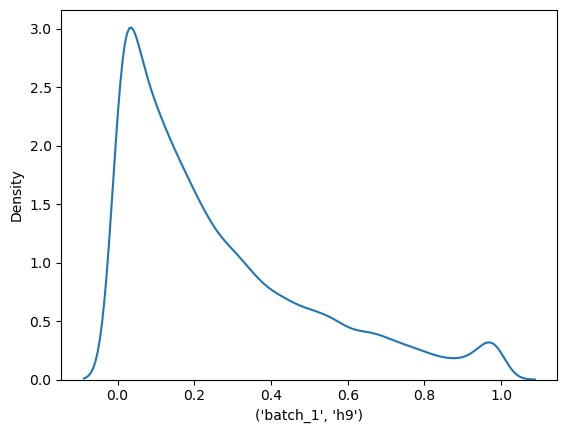

0.8076315885703207

In [94]:
#sns.kdeplot(data=rsq_df_10nt.loc[rsq_df_10nt['stage']=="h9"], x="rsq")
#sns.kdeplot(data=wide_rsq_df_10nt.dropna(), x="h9")
sns.kdeplot(data=wide_rsq_df.dropna(), x=("batch_1","h9"))
plt.show()
np.percentile(wide_rsq_df.dropna()[("batch_1","h9")], 95)

In [12]:
rsq_df = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.Mut_vs_Cov.genome.1nt..more5cells.remove_tenichreps.csv", header=[0], index_col=[0,1])
rsq_df['rsq'] = np.power(rsq_df['r'],2)
wide_rsq_df = rsq_df.reset_index().pivot(index=['gene','pos'], columns=['batch','stage'], values='rsq')
wide_rsq_df

batch              batch_1                                 batch_2            \
stage                 day0      day1      day7        h9      day0      day1   
gene        pos                                                                
AARS1       3058       NaN       NaN       NaN  0.728895       NaN       NaN   
            3059       NaN       NaN       NaN  0.003001       NaN       NaN   
            3060       NaN       NaN       NaN  0.862007       NaN       NaN   
            3061       NaN       NaN       NaN  0.438248       NaN       NaN   
            3062       NaN       NaN       NaN  0.393973       NaN       NaN   
...                    ...       ...       ...       ...       ...       ...   
human_small 1866  0.515769  0.700049  0.833442  0.822981  0.356102  0.525330   
            1867  0.586221  0.617221  0.741459  0.966736  0.747014  0.512077   
            1868  0.727247  0.803772  0.685847  0.912938  0.719111  0.596047   
            1869  0.743982  0.720285  0.677688  0.940725  0.693261  0.580685   
            1870  0.971789  0.995001  0.979199  0.996396  0.972004  0.960175   

batch                                 
stage                 day7        h9  
gene        pos                       
AARS1       3058       NaN  0.546097  
            3059       NaN  0.003493  
            3060       NaN  0.047360  
            3061       NaN  0.190307  
            3062       NaN  0.693062  
...                    ...       ...  
human_small 1866  0.720521  0.797704  
            1867  0.567624  0.895338  
            1868  0.594926  0.721215  
            1869  0.497781  0.734293  
            1870  0.978599  0.974076  

[597798 rows x 8 columns]

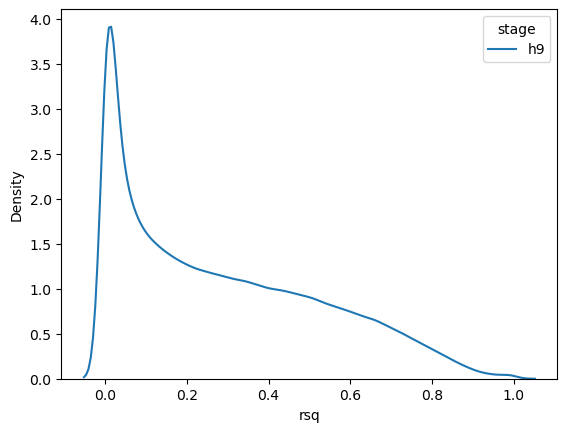

In [26]:
np.percentile(rsq_df.loc[(rsq_df['batch']=="batch_1")&(rsq_df['stage']=="h9"),'rsq'], 95)

0.741685473685938

In [48]:
h9_gnorm_reac.loc[h9_gnorm_reac.index.isin(rsq_df.loc[(rsq_df['batch']=="batch_1")&(rsq_df['stage']=="h9")&(rsq_df['rsq']>=0.75)].index)].dropna(how="any", thresh=0.5*h9_gnorm_reac.columns.size)

,,id,RHE1552,RHE1558,RHE1564,RHE1570,RHE1576,RHE1577,RHE1578,RHE1579,RHE1580,RHE1581,...,RHS3587,RHS3588,RHS3589,RHS3590,RHS3591,RHS3592,RHS3593,RHS3594,RHS3595,RHS3596
,,batch,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,...,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2
,,lib_type,single,single,single,single,single,single,single,single,single,single,...,single,single,single,single,single,single,single,single,single,single
id,batch,lib_type,,,,,,,,,,,,,,,,,,,,,
RHE1552,batch_1,single,1.000000,0.160932,0.231232,0.134186,0.220437,0.206534,0.319804,0.233236,0.267942,0.235842,...,0.033564,0.051333,0.013216,0.009941,0.021235,0.014256,0.149926,0.002129,0.006920,0.016016
RHE1558,batch_1,single,0.160932,1.000000,0.169638,0.082786,0.082077,0.132435,0.342757,0.260758,0.301154,0.141558,...,-0.011026,0.009050,0.023646,0.039484,0.026257,0.092617,0.029546,0.007379,0.018035,0.014035
RHE1564,batch_1,single,0.231232,0.169638,1.000000,0.163966,0.214187,0.238391,0.229863,0.253192,0.276518,0.229458,...,0.037209,0.038707,0.009488,0.026340,0.035757,0.018065,0.030603,0.023953,0.027408,0.040289
RHE1570,batch_1,single,0.134186,0.082786,0.163966,1.000000,0.091496,0.112550,0.084818,0.122113,0.152972,0.150367,...,0.034076,0.012951,0.002020,0.022979,0.007403,0.020645,0.021209,0.015429,0.016854,0.024821
RHE1576,batch_1,single,0.220437,0.082077,0.214187,0.091496,1.000000,0.271675,0.239397,0.211784,0.288018,0.333662,...,0.044577,0.067963,0.039759,0.036796,0.043322,0.063407,0.055462,0.023765,0.024348,0.079661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RHS3592,batch_2,single,0.014256,0.092617,0.018065,0.020645,0.063407,0.049111,0.079466,0.040184,0.063768,0.066702,...,0.048103,0.038472,0.034268,0.045785,0.045362,1.000000,0.030425,0.022479,0.034187,0.057890


5661 8056
3419 5591
1754 3727
606 2364
91 1488


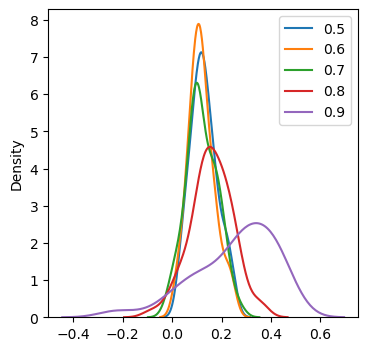

In [113]:
#h9_mosthomo_gnorm_reac = gnorm_reac.loc[gnorm_reac.index.isin(rsq_df.loc[(rsq_df['batch']=="batch_1")&(rsq_df['stage']=="h9")&(rsq_df['rsq']>=0.75),'rsq'].index), 
#                                       (gnorm_reac.columns.get_level_values('batch')=="batch_1")&(gnorm_reac.columns.get_level_values('stage')=="h9")]

temp_rsq = wide_rsq_df.dropna()[("batch_1","h9")]

fig, ax = plt.subplots(1,1, figsize=(4,4))

for threshold in [0.5,0.6,0.7,0.8,0.9]:
    bulk_mosthomo_reac = bulk_reac.loc[bulk_reac.index.isin(temp_rsq.loc[temp_rsq>threshold].index)]
    bulk_mosthomo_reac

    h9_mosthomo_reac = h9_crude_reac.loc[h9_crude_reac.index.isin(temp_rsq.loc[temp_rsq>threshold].index)]
    
    print (bulk_mosthomo_reac.index.size, h9_mosthomo_reac.index.size)
    bulk2h9_intersection = h9_mosthomo_reac.index.intersection(bulk_mosthomo_reac.index)

    h9_mosthomo_reac = h9_mosthomo_reac.loc[bulk2h9_intersection].sort_index()
    bulk_mosthomo_reac = bulk_mosthomo_reac.loc[bulk2h9_intersection].sort_index()
    bulk_mosthomo_reac = bulk_mosthomo_reac.iloc[:,[0,1]].mean(axis=1)
    bulk_mosthomo_reac

    sns.kdeplot(h9_mosthomo_reac.corrwith(bulk_mosthomo_reac), ax=ax, label=threshold)
plt.legend()
plt.show()

#### 1,x 

In [138]:
bulk2single_reac_rRNA = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.rRNA.gnorm_reac.csv", header=[0,1,2,3], index_col=[0,1])
bulk2single_reac = load_large_dataFrame("../Current_Data/04.Wide_Reac_Matrix_1nt/bulk2single.h9.transcripts.gnorm_reac.csv", header=[0,1,2,3], index_col=[0,1])

bulk2single_reac = bulk2single_reac.loc[bulk2single_reac.index.get_level_values('gene')!="human_small"]
bulk2single_reac = pd.concat([bulk2single_reac, bulk2single_reac_rRNA])
bulk2single_reac = bulk2single_reac.xs('batch_1', level="batch", axis=1)


bulk2single_reac_single = bulk2single_reac.xs('single', level="lib_type", axis=1, drop_level=False)
bulk2single_reac_bulk = bulk2single_reac.xs('bulk', level="lib_type", axis=1, drop_level=False)


1438
2231
3461
5158
7418


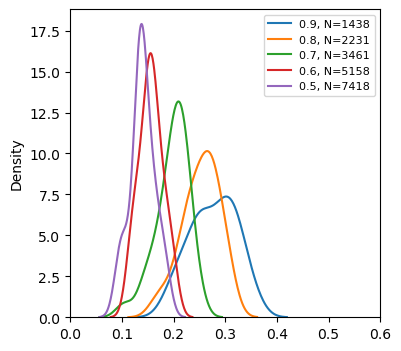

In [187]:

temp_rsq = wide_rsq_df.dropna()[("batch_1","h9")]
temp_rsq

fig, ax = plt.subplots(1,1, figsize=(4,4))

for threshold in [0.9,0.8,0.7,0.6,0.5]:
    selected_pos = temp_rsq.loc[temp_rsq>=threshold].index
    selected_pos = bulk2single_reac_single.index.intersection(bulk2single_reac_bulk.index).intersection(selected_pos)
    
    local_single = bulk2single_reac_single.loc[selected_pos].sort_index()
    local_bulk = bulk2single_reac_bulk.loc[selected_pos].sort_index()
    
    print (selected_pos.size)
    
    sns.kdeplot(local_single.corrwith(local_bulk.mean(axis=1), method="spearman"), ax=ax, 
                label="{}, N={}".format(threshold, selected_pos.size), common_norm=False)
ax.set_xlim(0.0,0.6)
plt.legend(fontsize=8)
plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/Correlation_bulk2single.reac.mosthomogeneous.nts.common_region_across_stages.pdf")
plt.show()


In [ ]:
bulk2single_mutrate = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
bulk2single_mutrate_rRNA = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/batch_1.h9.bulk2single.mutrate.1nt.rRNA.csv", header=[0,1,2,3,4], index_col=[0,1])

bulk2single_mutrate = bulk2single_mutrate.loc[bulk2single_mutrate.index.get_level_values('gene')!="human_small"]
bulk2single_mutrate = pd.concat([bulk2single_mutrate, bulk2single_mutrate_rRNA])
bulk2single_mutrate = bulk2single_mutrate.xs('batch_1', level="batch", axis=1)

bulk2single_mutrate_dmso = bulk2single_mutrate.xs('dmso', level="agent", axis=1, drop_level=False)
bulk2single_mutrate_nai = bulk2single_mutrate.xs('nai-n3', level="agent", axis=1, drop_level=False)
bulk2single_mutrate_dmso_single = bulk2single_mutrate_dmso.xs('single', level="lib_type", axis=1, drop_level=False)
bulk2single_mutrate_nai_single = bulk2single_mutrate_nai.xs('single', level="lib_type", axis=1, drop_level=False)

bulk2single_mutrate_dmso_bulk = bulk2single_mutrate_dmso.xs('bulk', level="lib_type", axis=1, drop_level=False)
bulk2single_mutrate_nai_bulk = bulk2single_mutrate_nai.xs('bulk', level="lib_type", axis=1, drop_level=False)
bulk2single_mutrate_dmso_bulk = bulk2single_mutrate_dmso_bulk.loc[bulk2single_mutrate_dmso_bulk.max(axis=1)<0.1]
bulk2single_mutrate_nai_bulk = bulk2single_mutrate_nai_bulk.loc[bulk2single_mutrate_dmso_bulk.index]

2959
15096
41523
80709
129492
186419
249972
320516
404403


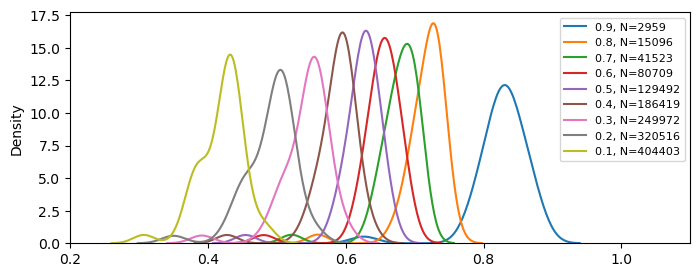

In [190]:
temp_rsq = wide_rsq_df[("batch_1","h9")]
temp_rsq
fig, ax = plt.subplots(1,1, figsize=(8,3))

for threshold in [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
    selected_pos = temp_rsq.loc[temp_rsq>=threshold].index
    selected_pos = bulk2single_mutrate_nai_single.index.intersection(bulk2single_mutrate_nai_bulk.index).intersection(selected_pos)
    
    local_single = bulk2single_mutrate_nai_single.loc[selected_pos].sort_index()
    local_bulk = bulk2single_mutrate_nai_bulk.loc[selected_pos].sort_index()
    
    print (selected_pos.size)
    
    
    sns.kdeplot(local_single.corrwith(local_bulk.mean(axis=1)), ax=ax, 
                label="{}, N={}".format(threshold, selected_pos.size), common_norm=False)
ax.set_xlim(0.2,1.1)
plt.legend(fontsize=8, loc="upper right")
plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/Correlation_bulk2single.mutrate.mosthomogeneous.nts.more_threshold.pdf")
plt.show()

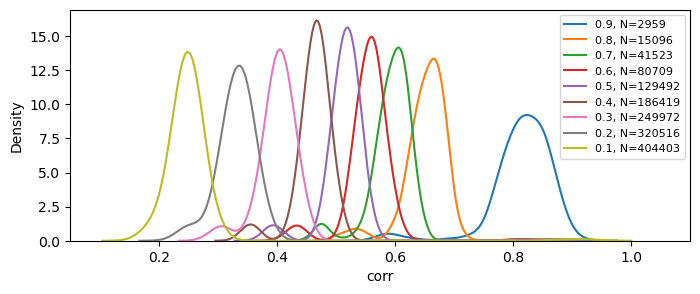

In [203]:
temp_rsq = wide_rsq_df[("batch_1","h9")]
temp_rsq
fig, ax = plt.subplots(1,1, figsize=(8,3))

for threshold in [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
    selected_pos = temp_rsq.loc[temp_rsq>=threshold].index
    selected_pos = bulk2single_mutrate_nai_single.index.intersection(bulk2single_mutrate_nai_bulk.index).intersection(selected_pos)
    
    local_single = bulk2single_mutrate_nai_single.loc[selected_pos].sort_index()
    local_bulk = bulk2single_mutrate_nai_bulk.loc[selected_pos].sort_index()
    
    local_corr = pd.DataFrame(np.triu(local_single.corr()), index=local_single.columns, columns=local_single.columns)
    local_corr = local_corr.replace(0, np.nan)
    local_corr = local_corr.replace(1, np.nan)
    local_corr = local_corr.stack([0,1,2,3]).to_frame('corr')
    
    #print (local_corr)
    
    
    sns.kdeplot( local_corr['corr'], ax=ax, 
                label="{}, N={}".format(threshold, selected_pos.size), common_norm=False)
    ax.set_xlim(0.05,1.1)
plt.legend(fontsize=8, loc="upper right")
plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/Correlation_single2single.mutrate.mosthomogeneous.nts.more_threshold.pdf")
plt.show()

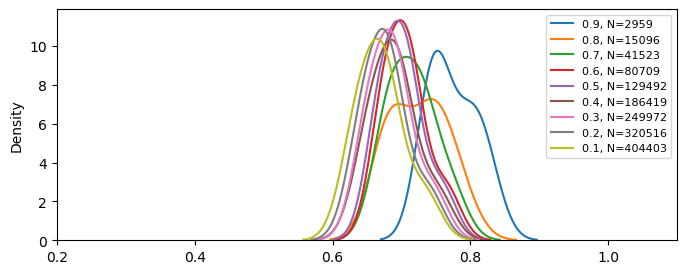

In [193]:
temp_rsq = wide_rsq_df[("batch_1","h9")]
temp_rsq

    
fig, ax = plt.subplots(1,1, figsize=(8,3))

for threshold in [0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]:
    selected_pos = temp_rsq.loc[temp_rsq>=threshold].index
    selected_pos = bulk2single_mutrate_dmso_single.index.intersection(bulk2single_mutrate_dmso_bulk.index).intersection(selected_pos)
    
    local_single = bulk2single_mutrate_dmso_single.loc[selected_pos].sort_index()
    local_bulk = bulk2single_mutrate_dmso_bulk.loc[selected_pos].sort_index()
        
    sns.kdeplot(local_single.corrwith(local_bulk.mean(axis=1)), ax=ax,  
                label="{}, N={}".format(threshold, selected_pos.size), common_norm=False)
ax.set_xlim(0.2,1.1)
plt.legend(fontsize=8)
plt.savefig("../Current_Figures/02. rRNA_reactivity_correlation/Correlation_bulk2single.mutrate.dmso.mosthomogeneous.nts.more_threshold.pdf")
plt.show()

In [32]:
gene_h9_crude_reac_stacked = gene_h9_crude_reac.stack([0,1]).to_frame('reac').reset_index()
gene_h9_crude_reac_stacked 

,pos,id,lib_type,reac
0,1835,RHE1552,single,-0.005966
1,1835,RHE1577,single,-0.005966
2,1835,RHE1578,single,-0.003188
3,1835,RHE1581,single,0.000344
4,1835,RHE1582,single,0.069877
...,...,...,...,...
7665,2132,RHE1614,single,-0.003868
7666,2132,RHE1615,single,0.003431
7667,2132,RHE1653,single,0.008327
7668,2132,RHE1654,single,-0.001113


## 2. Plot heatmap of single genes

In [31]:
common_genes = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/common gene btw_htg_from_crude_reac_and_qnorm_reac.csv")
common_genes

Index(['PRDX4', 'FIBP', 'VCP', 'POLR3K', 'PGK1', 'CCT3', 'ECHS1', 'STIP1',
       'PHB2', 'PCBP1',
       ...
       'ARPC3', 'MAP1B', 'PFN2', 'HNRNPR', 'SEPTIN7', 'CAPZA1', 'ATP5PB',
       'EIF3A', 'YWHAQ', 'SRP9'],
      dtype='object', name='common_genes', length=115)

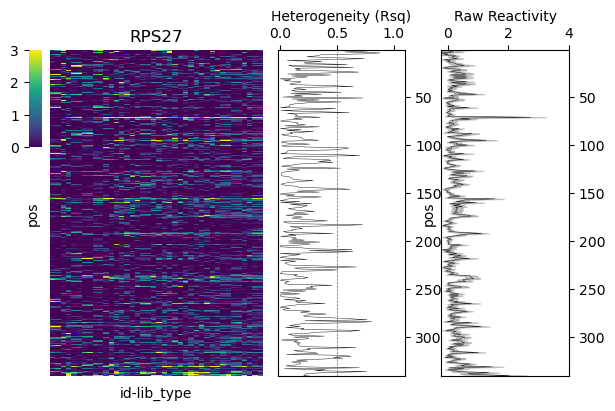

In [26]:
gene = "RPS27"

#for gene in ['RPS27', 'RPL13A', 'FKBP4']:


#
#for gene in ['RPS29','RPL37A','RPL13A','RPL30','ATP5F1E','RPL5']:
#for gene in ['RPS29','RPL13A','RPS15A','RPL13A','ATP5F1E','MZT2A']:
#for gene in ['MTCH2','SLC25A5','ATP6V1G1','UCHL1','CD63']:
#or gene in common_genes.index:
#for gene in ['AHCY','EIF5','ARPC2','SKP1','ATP6V1G1','S100A10','COPS6','MTCH2']:
for gene in ['RPS27']:
    
    #gene_h9_crude_reac = h9_crude_reac_10nt.loc[gene]
    if gene not in h9_crude_reac.index.get_level_values('gene'):
        continue
    #gene_h9_crude_reac = h9_crude_reac.loc[gene]
    gene_h9_crude_reac = h9_gnorm_reac.loc[gene]

    
    gene_h9_crude_reac = gene_h9_crude_reac.dropna(how="any", thresh=0.8*gene_h9_crude_reac.index.size,  axis=1)
    gene_h9_crude_reac = gene_h9_crude_reac.dropna()
    #gene_h9_crude_reac = gene_h9_crude_reac.xs('batch_1', level='batch', axis=1)
    
    if  (gene_h9_crude_reac.index.size < 300) | (gene_h9_crude_reac.columns.size < 20):
        continue
    
    # h = sns.clustermap(gene_h9_crude_reac, vmin=-0.25, vmax=2, cmap="viridis", row_cluster=False, col_cluster=True, figsize=(3,5))
    # plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/reac2rsq.{}.crude_reac.clusted.heatmap.viridis.pdf".format(gene))
    # plt.show()
    dgram = h.dendrogram_col.dendrogram
    gene_h9_crude_reac.iloc[:,dgram['leaves']]
    #dgram.keys()

    gene_rsq_df = wide_rsq_df.loc[gene].xs('h9', level="stage", axis=1).reset_index()
    #gene_rsq_df = wide_rsq_df_10nt.loc[gene][['h9']]
    #gene_rsq_df.columns = ['batch_1']
    gene_rsq_df = gene_rsq_df.reset_index()
    gene_rsq_df = gene_rsq_df.loc[gene_rsq_df['pos'].isin(gene_h9_crude_reac.index.get_level_values('pos'))]
    
    gene_h9_crude_reac_stacked = gene_h9_crude_reac.stack(list(range(gene_h9_crude_reac.columns.nlevels))).to_frame('reac').reset_index()
    gene_h9_crude_reac_stacked
    

    fig = plt.figure(constrained_layout=False, figsize=(8,7))
    gridspec = fig.add_gridspec(nrows=60, ncols=90, left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1, hspace=0.1)
    heatmap_cbar_ax = fig.add_subplot(gridspec[12:24, 7:9])
    reac_heatmap_ax = fig.add_subplot(gridspec[12:52, 10:40])
    rsq_curve_ax = fig.add_subplot(gridspec[12:52, 42:60])
    reac_curve_ax = fig.add_subplot(gridspec[12:52, 65:83])
    #sns.heatmap(gene_h9_crude_reac.iloc[:,dgram['leaves']].sort_index(), vmin=0, vmax=0.06, cmap="viridis", ax=reac_heatmap_ax, cbar_ax=heatmap_cbar_ax,  #viridis
    #            xticklabels=False, yticklabels=False)
    sns.heatmap(gene_h9_crude_reac.iloc[:,dgram['leaves']].sort_index(), vmin=0, vmax=3, cmap="viridis", ax=reac_heatmap_ax, cbar_ax=heatmap_cbar_ax,  #viridis
                xticklabels=False, yticklabels=False)
    reac_heatmap_ax.set_title(gene)
    #sns.lineplot(data=gene_rsq_df, x="pos", y="batch_1", ax=rsq_curve_ax, orientation='vertica')
    rsq_curve_ax.plot(gene_rsq_df["batch_1"], gene_rsq_df['pos'], lw=0.3, color="black")
    heatmap_cbar_ax.yaxis.tick_left()

    #eac_curve_ax.plot(gene_h9_crude_reac_stacked['reac'],gene_h9_crude_reac_stacked['pos'], lw=0.3, color="black")
    sns.lineplot(data=gene_h9_crude_reac_stacked, x='reac', y="pos", orient="y", ax=reac_curve_ax, color="black",  lw=0.3)
    reac_curve_ax.set_xlim(-0.2, 4)
    reac_curve_ax.set_ylim(gene_h9_crude_reac.index.get_level_values('pos').min(), gene_h9_crude_reac.index.get_level_values('pos').max())
    reac_curve_ax.invert_yaxis()
    reac_curve_ax.yaxis.tick_right()
    reac_curve_ax.set_xlabel('Raw Reactivity', loc="center")
    reac_curve_ax.xaxis.tick_top()
    reac_curve_ax.xaxis.set_label_position('top')
    
    rsq_curve_ax.set_ylim(gene_h9_crude_reac.index.get_level_values('pos').min(), gene_h9_crude_reac.index.get_level_values('pos').max())
    rsq_curve_ax.invert_yaxis()
    rsq_curve_ax.yaxis.tick_right()
    rsq_curve_ax.set_xlabel('Heterogeneity (Rsq)', loc="center")
    rsq_curve_ax.set_xlim(-0.02,1.1)
    rsq_curve_ax.xaxis.tick_top()
    rsq_curve_ax.xaxis.set_label_position('top')
    rsq_curve_ax.axvline(x=0.5, lw=0.5, ls='--')
    plt.tight_layout()
    
    #plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/reac2rsq.{}.crude_reac.heatmap.viridis.pdf".format(gene))
    plt.show()

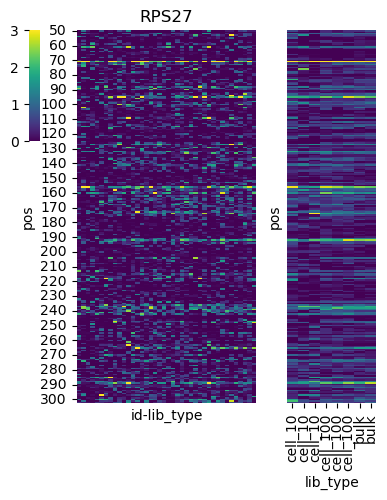

In [22]:
for gene in ['RPS27']:
    
    #gene_h9_crude_reac = h9_crude_reac_10nt.loc[gene]
    if gene not in h9_crude_reac.index.get_level_values('gene'):
        continue
    #gene_h9_crude_reac = h9_crude_reac.loc[gene]
    gene_h9_crude_reac = h9_gnorm_reac.loc[gene]
    bulk_gene_reac = bulk_reac.loc[gene]
    gene_h9_crude_reac = gene_h9_crude_reac.loc[gene_h9_crude_reac.index.intersection(bulk_gene_reac.index)].sort_index()
    bulk_gene_reac = bulk_gene_reac.loc[gene_h9_crude_reac.index.intersection(bulk_gene_reac.index)].sort_index()
    t = pd.CategoricalDtype(categories=['cell_10','cell_100','bulk'], ordered=True)
    bulk_gene_reac.columns = bulk_gene_reac.columns.astype(t)
    bulk_gene_reac.sort_index(axis=1, inplace=True)
    #bulk_gene_reac = bulk_gene_reac.loc[:, ()]
    #print (gene_h9_crude_reac)
    #print (bulk_gene_reac)
    
    gene_h9_crude_reac = gene_h9_crude_reac.dropna(how="any", thresh=0.8*gene_h9_crude_reac.index.size,  axis=1)
    gene_h9_crude_reac = gene_h9_crude_reac.dropna()
    
    
    gene_h9_crude_reac = gene_h9_crude_reac.xs('batch_1', level='batch', axis=1)
    
    if  (gene_h9_crude_reac.index.size < 100) | (gene_h9_crude_reac.columns.size < 20):
        continue
    
    # h = sns.clustermap(gene_h9_crude_reac, vmin=-0.25, vmax=2, cmap="viridis", row_cluster=False, col_cluster=True, figsize=(3,5))
    # plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/reac2rsq.{}.crude_reac.clusted.heatmap.viridis.pdf".format(gene))
    # plt.show()
    #dgram = h.dendrogram_col.dendrogram
    #gene_h9_crude_reac.iloc[:,dgram['leaves']]
    
    col_order = gene_h9_crude_reac.sort_index(axis=1).columns.to_list()
    random.shuffle(col_order)
    gene_h9_crude_reac = gene_h9_crude_reac.loc[:,  col_order]
    #dgram.keys()

    
    gene_h9_crude_reac_stacked = gene_h9_crude_reac.stack(list(range(gene_h9_crude_reac.columns.nlevels))).to_frame('reac').reset_index()
    gene_h9_crude_reac_stacked
    

    fig = plt.figure(constrained_layout=False, figsize=(6,8))
    gridspec = fig.add_gridspec(nrows=60, ncols=80, left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1, hspace=0.1)
    heatmap_cbar_ax = fig.add_subplot(gridspec[12:24, 7:9])
    reac_heatmap_ax = fig.add_subplot(gridspec[12:52, 15:45])
    
    
    bulk_heatmap_ax = fig.add_subplot(gridspec[12:52, 50:65])
    #reac_curve_ax = fig.add_subplot(gridspec[12:52, 65:83])
    #sns.heatmap(gene_h9_crude_reac.iloc[:,dgram['leaves']].sort_index(), vmin=0, vmax=0.06, cmap="viridis", ax=reac_heatmap_ax, cbar_ax=heatmap_cbar_ax,  #viridis
    #            xticklabels=False, yticklabels=False)
    sns.heatmap(gene_h9_crude_reac, vmin=0, vmax=3, cmap="viridis", ax=reac_heatmap_ax, cbar_ax=heatmap_cbar_ax,  #viridis
                xticklabels=False)
    sns.heatmap(bulk_gene_reac, vmin=0, vmax=3, cmap="viridis", ax=bulk_heatmap_ax, cbar=False,  #viridis
                xticklabels=True, yticklabels=False)
    reac_heatmap_ax.set_title(gene)
    #sns.lineplot(data=gene_rsq_df, x="pos", y="batch_1", ax=rsq_curve_ax, orientation='vertica')
    #rsq_curve_ax.plot(gene_rsq_df["batch_1"], gene_rsq_df['pos'], lw=0.3, color="black")
    heatmap_cbar_ax.yaxis.tick_left()
    for label in bulk_heatmap_ax.get_yticklabels():
        label.set_rotation(270)
    #plt.tight_layout()
    
    plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/reac2rsq.{}.gnorm_reac.single2bulk.heatmap.viridis.pdf".format(gene))
    plt.show()

In [63]:
print ([random.shuffle()])

TypeError: shuffle() missing 1 required positional argument: 'x'

### 2.1 

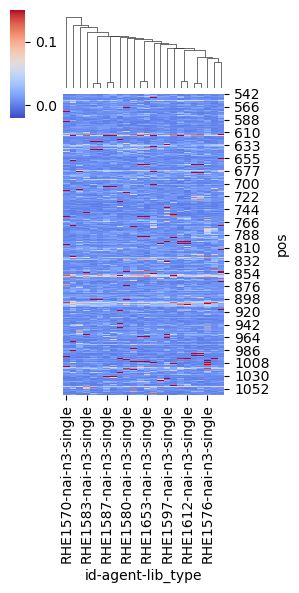

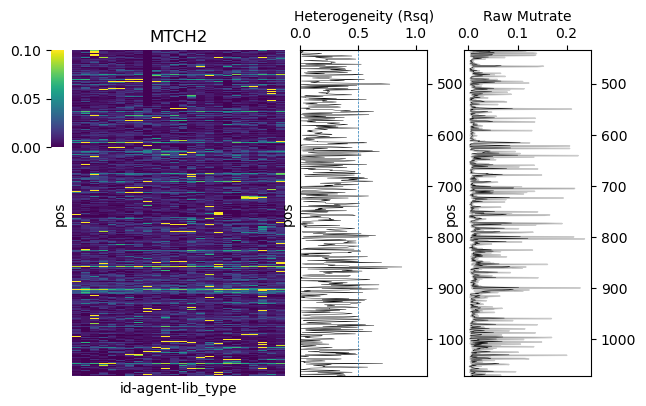

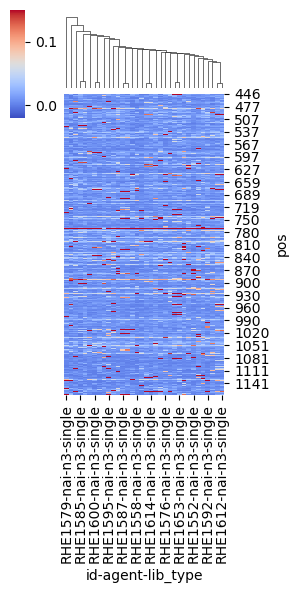

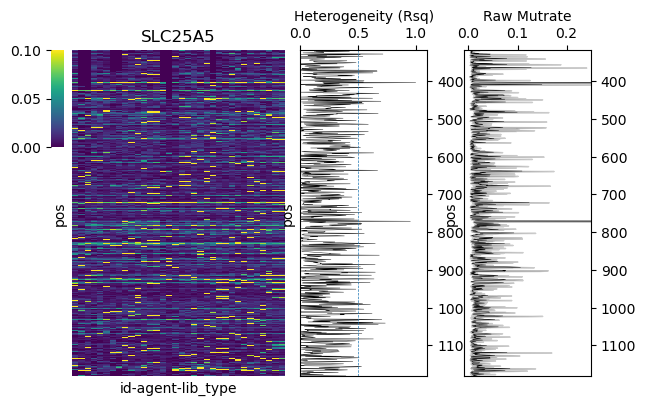

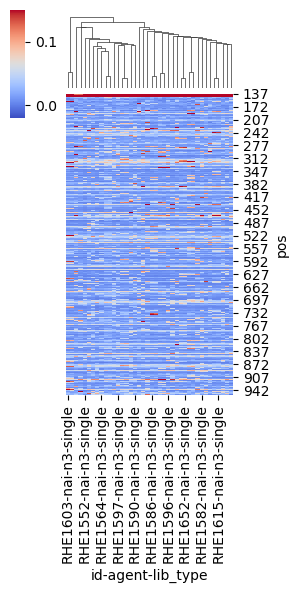

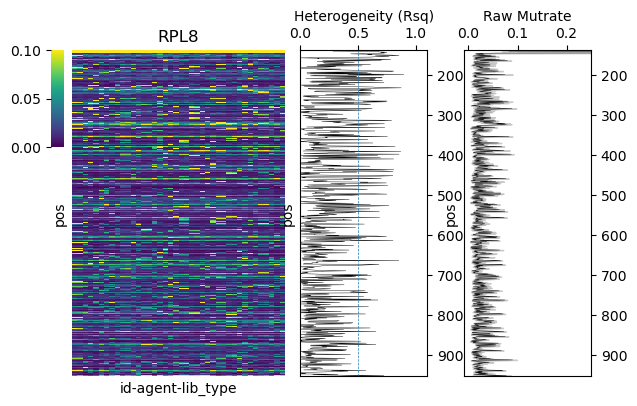

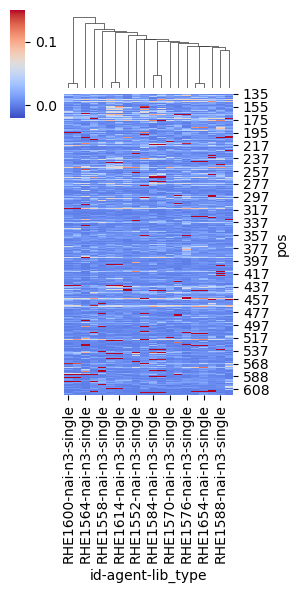

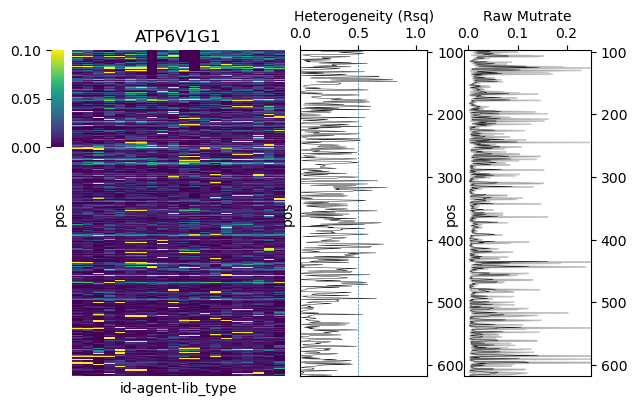

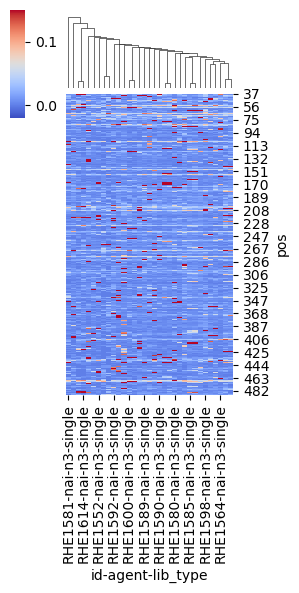

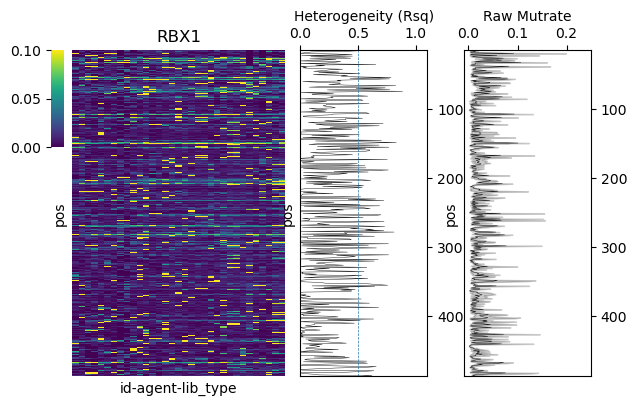

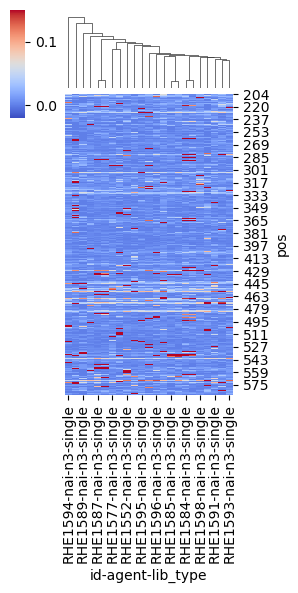

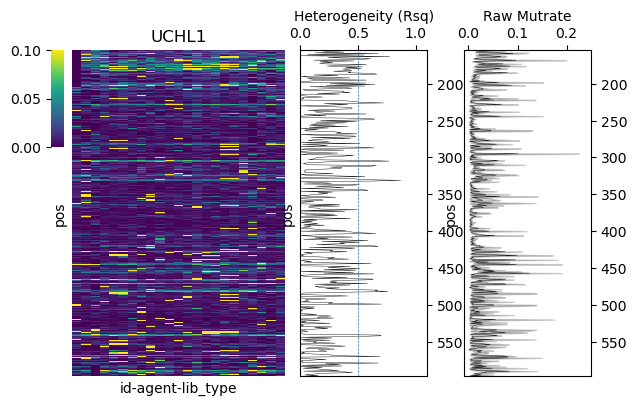

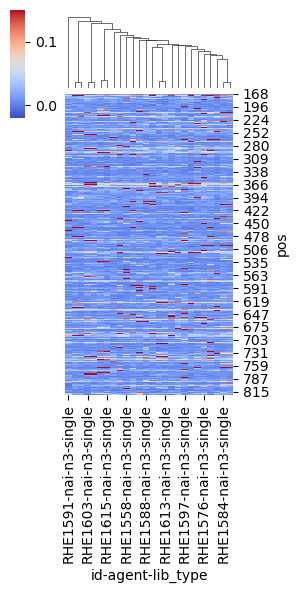

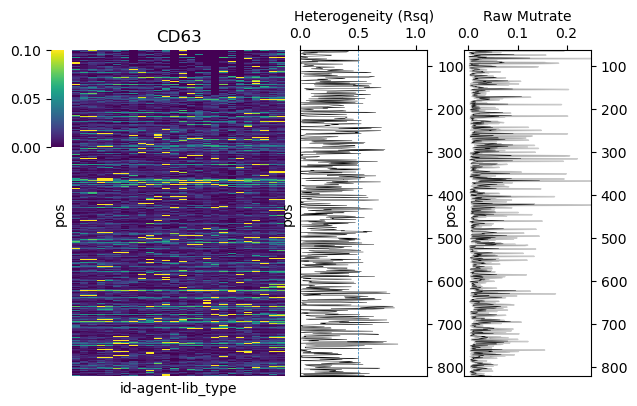

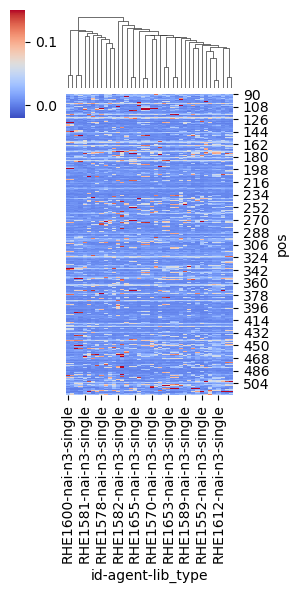

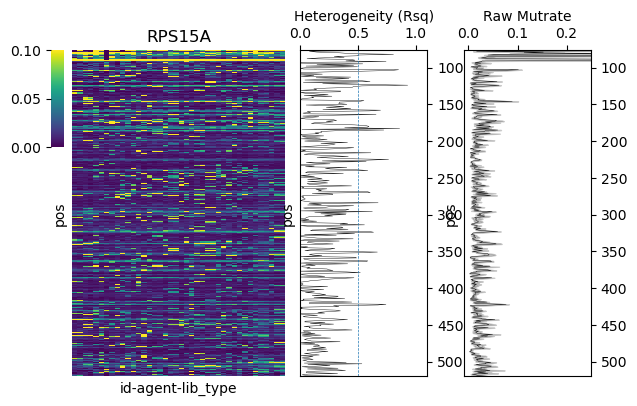

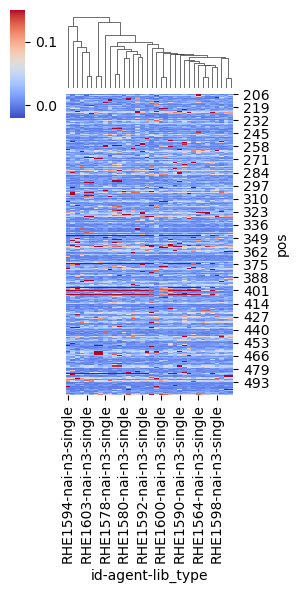

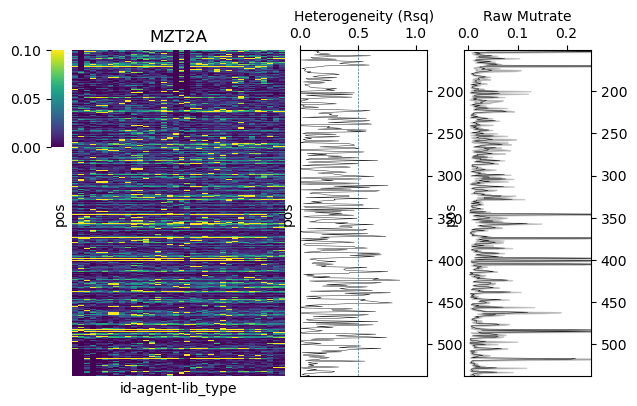

In [11]:
for gene in ['MTCH2','SLC25A5','ATP6V1G1','UCHL1','CD63']:
    #gene_h9_crude_reac = h9_crude_reac_10nt.loc[gene]
    gene_h9_crude_reac = h9_mutrate.loc[gene]
    #gene_h9_crude_reac = h9_gnorm_reac.loc[gene]
    
    gene_h9_crude_reac = gene_h9_crude_reac.dropna(how="any", thresh=0.8*gene_h9_crude_reac.index.size,  axis=1)
    gene_h9_crude_reac = gene_h9_crude_reac.iloc[10:-10]
    gene_h9_crude_reac = gene_h9_crude_reac.xs('batch_1', level='batch', axis=1)
    #gene_h9_crude_reac = gene_h9_crude_reac.dropna()
    
    h = sns.clustermap(gene_h9_crude_reac.dropna(), cmap="coolwarm", row_cluster=False, col_cluster=True, vmin=-0.02, vmax=0.15, figsize=(3,6))
    plt.show()
    dgram = h.dendrogram_col.dendrogram
    gene_h9_crude_reac.iloc[:,dgram['leaves']]
    #dgram.keys()

    gene_rsq_df = wide_rsq_df.loc[gene].xs('h9', level="stage", axis=1).reset_index()
    #gene_rsq_df = wide_rsq_df_10nt.loc[gene][['h9']]
    #gene_rsq_df.columns = ['batch_1']
    gene_rsq_df = gene_rsq_df.reset_index()
    gene_rsq_df = gene_rsq_df.loc[gene_rsq_df['pos'].isin(gene_h9_crude_reac.index.get_level_values('pos'))]
    
    gene_h9_crude_reac_stacked = gene_h9_crude_reac.stack(list(range(gene_h9_crude_reac.columns.nlevels))).to_frame('reac').reset_index()
    gene_h9_crude_reac_stacked
    

    fig = plt.figure(constrained_layout=False, figsize=(8,7))
    gridspec = fig.add_gridspec(nrows=60, ncols=90, left=0.1, right=0.9, bottom=0.2, top=0.9, wspace=0.1, hspace=0.1)
    heatmap_cbar_ax = fig.add_subplot(gridspec[12:24, 7:9])
    reac_heatmap_ax = fig.add_subplot(gridspec[12:52, 10:40])
    rsq_curve_ax = fig.add_subplot(gridspec[12:52, 42:60])
    reac_curve_ax = fig.add_subplot(gridspec[12:52, 65:83])
    sns.heatmap(gene_h9_crude_reac.iloc[:,dgram['leaves']].sort_index().fillna(0), vmin=0, vmax=0.1, cmap="viridis", ax=reac_heatmap_ax, cbar_ax=heatmap_cbar_ax,  #viridis
                xticklabels=False, yticklabels=False)
    reac_heatmap_ax.set_title(gene)
    #sns.lineplot(data=gene_rsq_df, x="pos", y="batch_1", ax=rsq_curve_ax, orientation='vertica')
    #rsq_curve_ax.plot(gene_rsq_df["batch_1"], gene_rsq_df['pos'], lw=0.3, color="black")
    sns.lineplot(data=gene_rsq_df, x='batch_1', y="pos", orient="y", ax=rsq_curve_ax, color="black", lw=0.3)
    heatmap_cbar_ax.yaxis.tick_left()

    #reac_curve_ax.plot(gene_h9_crude_reac_stacked['reac'],gene_h9_crude_reac_stacked['pos'], lw=0.3, color="black")
    sns.lineplot(data=gene_h9_crude_reac_stacked, x='reac', y="pos", orient="y", ax=reac_curve_ax, color="black",  lw=0.3)
    reac_curve_ax.set_xlim(-0.01, 0.25)
    reac_curve_ax.set_ylim(gene_h9_crude_reac.index.get_level_values('pos').min(), gene_h9_crude_reac.index.get_level_values('pos').max())
    reac_curve_ax.invert_yaxis()
    reac_curve_ax.yaxis.tick_right()
    reac_curve_ax.set_xlabel('Raw Mutrate', loc="center")
    reac_curve_ax.xaxis.tick_top()
    reac_curve_ax.xaxis.set_label_position('top')
    
    rsq_curve_ax.set_ylim(gene_h9_crude_reac.index.get_level_values('pos').min(), gene_h9_crude_reac.index.get_level_values('pos').max())
    rsq_curve_ax.invert_yaxis()
    rsq_curve_ax.yaxis.tick_right()
    rsq_curve_ax.set_xlabel('Heterogeneity (Rsq)', loc="center")
    rsq_curve_ax.set_xlim(0,1.1)
    rsq_curve_ax.xaxis.tick_top()
    rsq_curve_ax.xaxis.set_label_position('top')
    rsq_curve_ax.axvline(x=0.5, lw=0.5, ls='--')
    plt.tight_layout()
    
    #plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/reac2rsq.{}.mutrate.heatmap.viridis.pdf".format(gene))
    plt.show()

## 3. Density Plot of Rsq in single gene

RPL13A
MTCH2


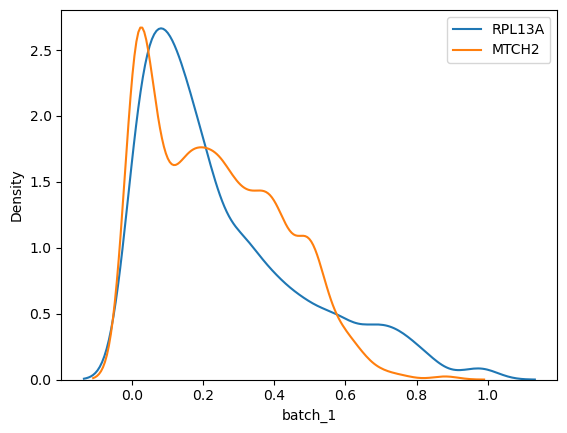

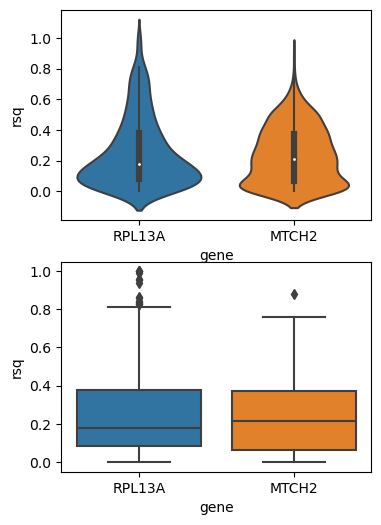

RPL13A
SLC25A5


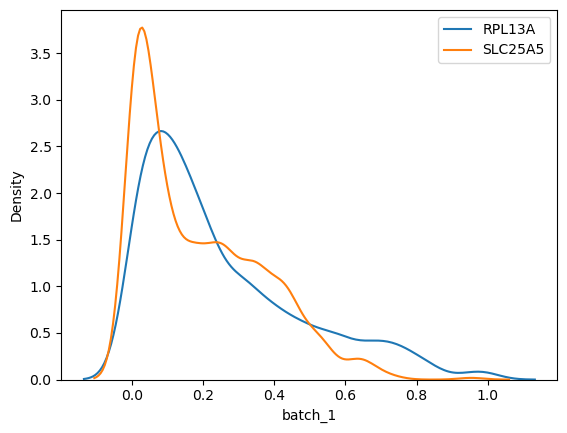

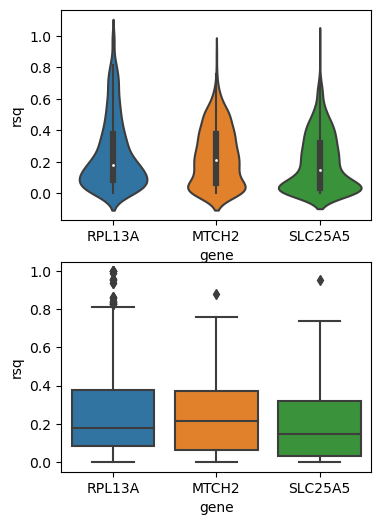

RPL13A
RPL8


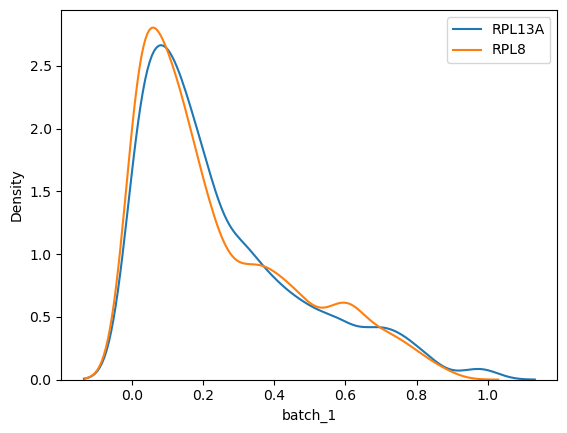

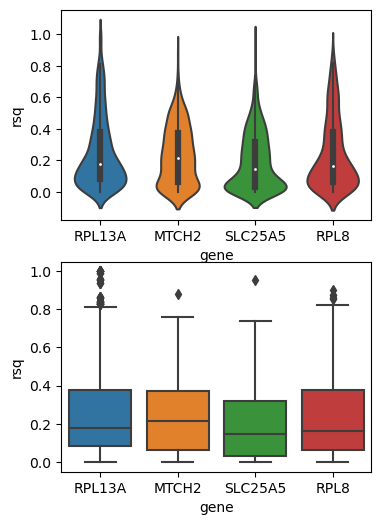

RPL13A
ATP6V1G1


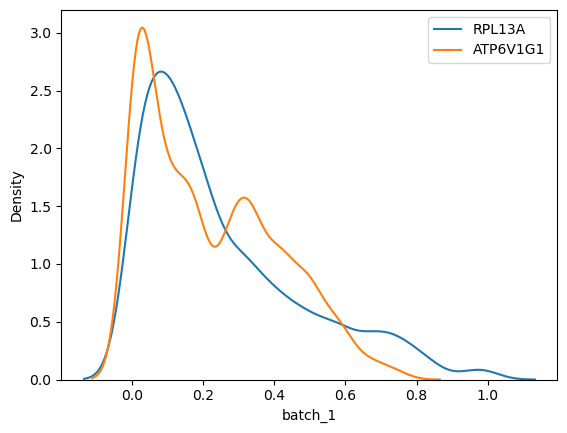

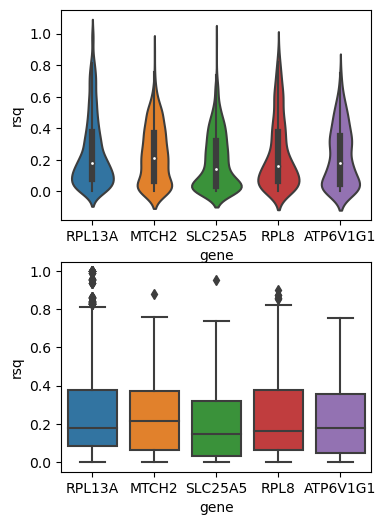

RPL13A
RBX1


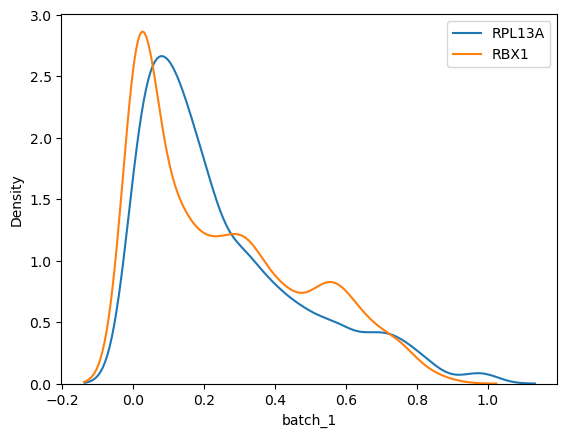

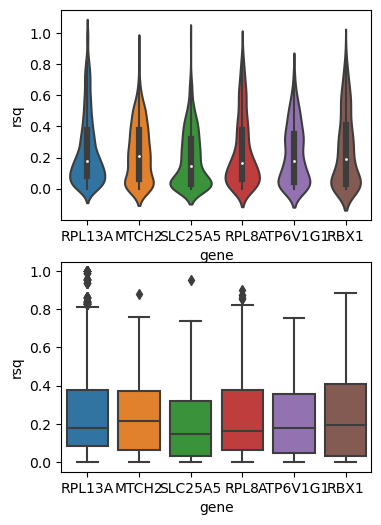

RPL13A
UCHL1


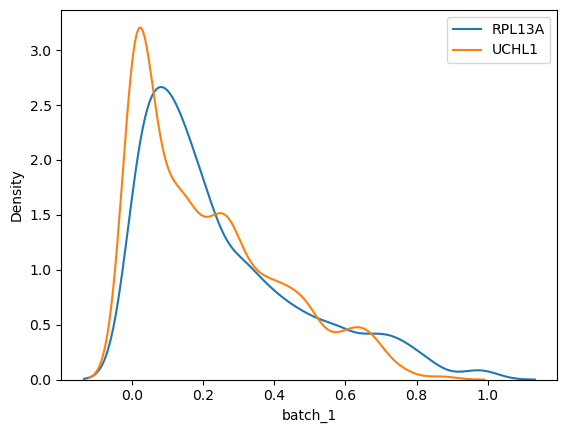

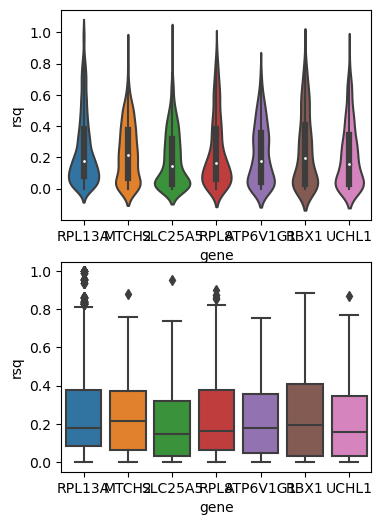

RPL13A
CD63


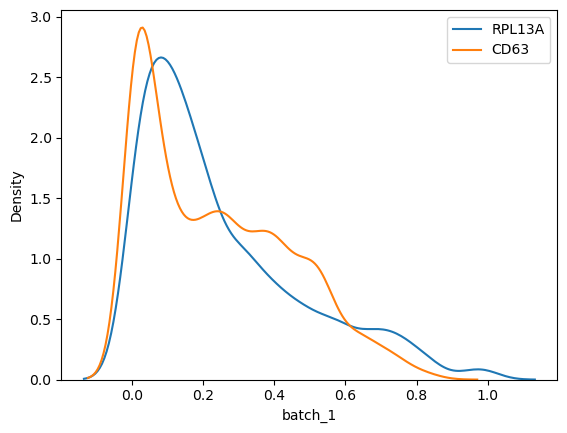

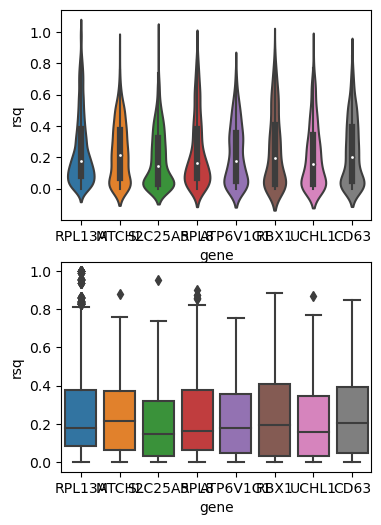

RPL13A
RPS15A


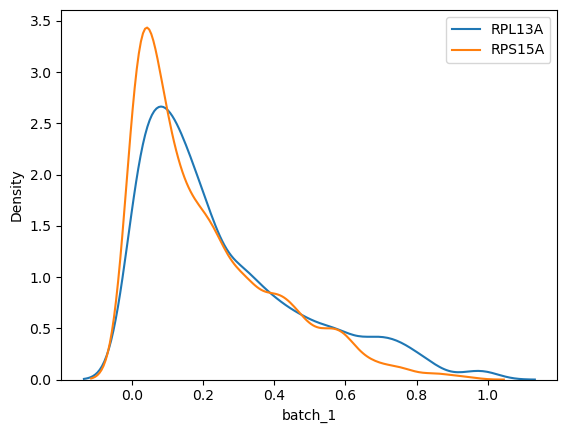

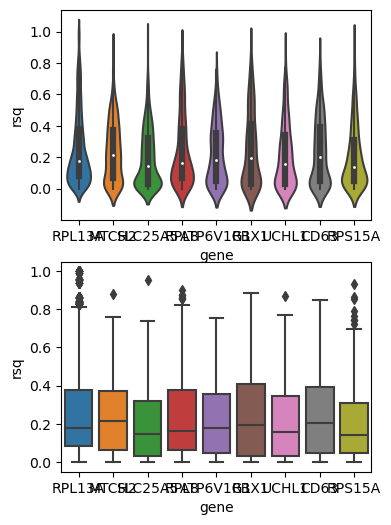

RPL13A
MZT2A


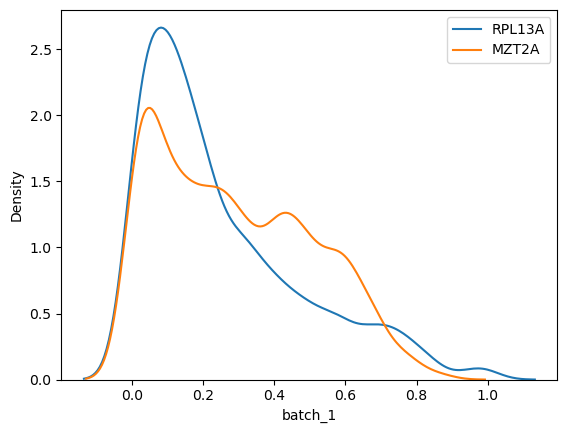

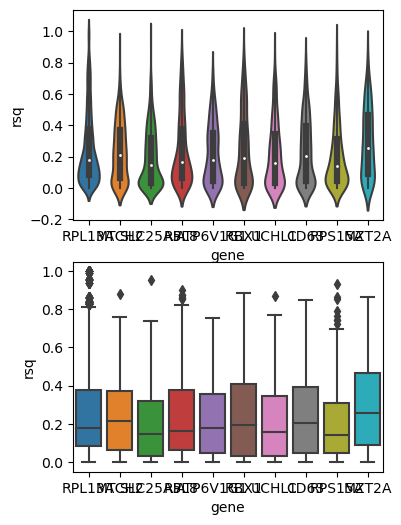

In [7]:
gene = "RPL13A"

fig, ax = plt.subplots(1,1)
#for gene in ['RPS27', 'RPL13A', 'FKBP4']:

#for gene in hetero_genes:

concat_lst  = []
#for gene in ['RPL13A','RPS29','RPL37','RPL39','RPL26','RPS24']:  ## ,'RPS29','RPS15A', 'SKP1','DDX5',
#for gene in ['RPL13A','RPL37A','ATP5F1E','RPL5']:  ## ,'RPS29','RPS15A', 'SKP1','DDX5', 'RPS29','RPS29',
for gene1 in ['MTCH2','SLC25A5','RPL8','ATP6V1G1','RBX1','UCHL1','CD63','RPS15A','MZT2A']:

   
    for gene in ['RPL13A',gene1]:  ## ,'RPS29','RPS15A', 'SKP1','DDX5', 'RPS29','RPS29',
    
        print (gene)
        #gene_h9_crude_reac = h9_crude_reac_10nt.loc[gene]
        gene_h9_crude_reac = h9_crude_reac.loc[gene]
        #gene_h9_crude_reac = h9_gnorm_reac.loc[gene]

        gene_h9_crude_reac = gene_h9_crude_reac.dropna(how="any", thresh=0.8*gene_h9_crude_reac.index.size,  axis=1)
        gene_h9_crude_reac = gene_h9_crude_reac.dropna()
        gene_h9_crude_reac = gene_h9_crude_reac.xs('batch_1', level='batch', axis=1)


        #h = sns.clustermap(gene_h9_crude_reac, cmap="coolwarm", row_cluster=False, col_cluster=True, vmin=-0.02, vmax=0.05, figsize=(3,6))
        #plt.show()
        #dgram = h.dendrogram_col.dendrogram
        #gene_h9_crude_reac.iloc[:,dgram['leaves']]
        #dgram.keys()

        gene_rsq_df = wide_rsq_df.loc[gene].xs('h9', level="stage", axis=1).reset_index()
        #gene_rsq_df = wide_rsq_df_10nt.loc[gene][['h9']]
        #gene_rsq_df.columns = ['batch_1']
        gene_rsq_df = gene_rsq_df.reset_index()
        gene_rsq_df = gene_rsq_df.loc[gene_rsq_df['pos'].isin(gene_h9_crude_reac.index.get_level_values('pos'))]

        #print (gene_rsq_df)
        #sns.histplot(data=gene_rsq_df, x="batch_1", label=gene, stat='probability')
        sns.kdeplot(data=gene_rsq_df, x="batch_1", label=gene, common_norm=False, bw_method=0.2) #, bw_adjust=0.5
        gene_rsq_df['gene'] = gene
        concat_lst.append(gene_rsq_df)
    plt.legend()
    #plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/reac2rsq.rsq_density_for_each_gene.kdeplot.pdf")
    plt.show()


    gene_rsq_df = pd.concat(concat_lst)
    gene_rsq_df.rename(columns={'batch_1':'rsq'}, inplace=True)
    fig, axs = plt.subplots(2,1, figsize=(4,6))
    sns.violinplot(data=gene_rsq_df, x='gene', y="rsq", ax=axs[0])
    sns.boxplot(data=gene_rsq_df, x='gene', y="rsq", ax=axs[1])
    #plt.savefig("../Current_Figures/06.Heterogeneity_Distribution/reac2rsq.rsq_density_for_each_gene.boxplot.pdf")
    plt.show()

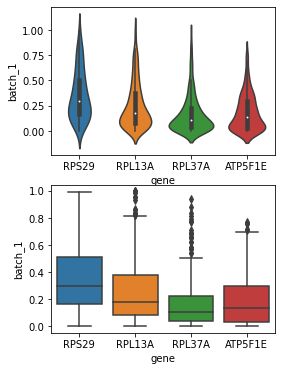

In [230]:

#gene_rsq_df

RPS29
RPL13A
RPL37A
RPL26
RPL30
TUBB2B
RPS8
TMSB10
RPL39
RPS25
ATP5F1E
RPL8
RPL4
RPL5


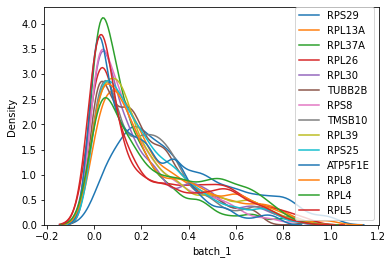

In [170]:
gene = "RPL13A"

fig, ax = plt.subplots(1,1)
#for gene in ['RPS27', 'RPL13A', 'FKBP4']:

#for gene in hetero_genes:

concat_lst  = []
#for gene in ['RPL13A','RPS29','RPL37','RPL39','RPL26','RPS24']:  ## ,'RPS29','RPS15A', 'SKP1','DDX5',
for gene in ['RPS29','RPL13A','RPL37A','RPL26','RPL30','TUBB2B','RPS8','TMSB10','RPL39','RPS25','ATP5F1E','RPL8','RPL4','RPL5']:  ## ,'RPS29','RPS15A', 'SKP1','DDX5', 'RPS29',
    
    print (gene)
    #gene_h9_crude_reac = h9_crude_reac_10nt.loc[gene]
    gene_h9_crude_reac = h9_crude_reac.loc[gene]
    #gene_h9_crude_reac = h9_gnorm_reac.loc[gene]
    
    gene_h9_crude_reac = gene_h9_crude_reac.dropna(how="any", thresh=0.8*gene_h9_crude_reac.index.size,  axis=1)
    gene_h9_crude_reac = gene_h9_crude_reac.dropna()
    gene_h9_crude_reac = gene_h9_crude_reac.xs('batch_1', level='batch', axis=1)
    
    
    #h = sns.clustermap(gene_h9_crude_reac, cmap="coolwarm", row_cluster=False, col_cluster=True, vmin=-0.02, vmax=0.05, figsize=(3,6))
    #plt.show()
    #dgram = h.dendrogram_col.dendrogram
    #gene_h9_crude_reac.iloc[:,dgram['leaves']]
    #dgram.keys()

    gene_rsq_df = wide_rsq_df.loc[gene].xs('h9', level="stage", axis=1).reset_index()
    #gene_rsq_df = wide_rsq_df_10nt.loc[gene][['h9']]
    #gene_rsq_df.columns = ['batch_1']
    gene_rsq_df = gene_rsq_df.reset_index()
    gene_rsq_df = gene_rsq_df.loc[gene_rsq_df['pos'].isin(gene_h9_crude_reac.index.get_level_values('pos'))]
    
    #print (gene_rsq_df)
    #sns.histplot(data=gene_rsq_df, x="batch_1", label=gene, stat='probability')
    sns.kdeplot(data=gene_rsq_df, x="batch_1", label=gene, common_norm=False, bw_method=0.2) #, bw_adjust=0.5
    gene_rsq_df['gene'] = gene
    concat_lst.append(gene_rsq_df)
plt.legend()
plt.show()

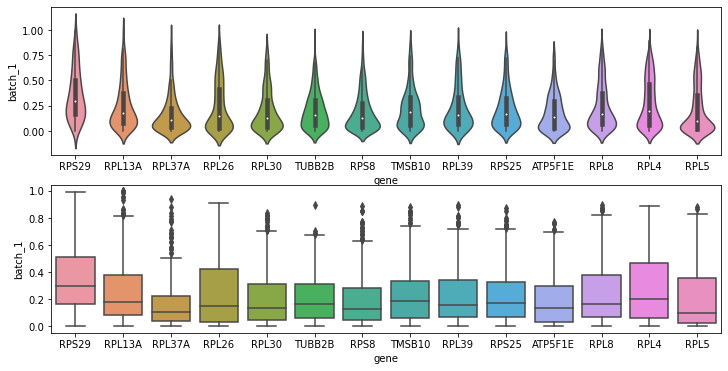

In [171]:

gene_rsq_df = pd.concat(concat_lst)
fig, axs = plt.subplots(2,1, figsize=(12,6))
sns.violinplot(data=gene_rsq_df, x='gene', y="batch_1", ax=axs[0])
sns.boxplot(data=gene_rsq_df, x='gene', y="batch_1", ax=axs[1])
plt.show()
#gene_rsq_df

## 4. recalculate the Rsq to remove teniqual replicates

In [2]:
## Retrieve mutant matrix
b1_h9_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.h9.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_mutant = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.mutant.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

h9_mutant = pd.concat([b1_h9_mutant, b2_h9_mutant], axis=1)
day0_mutant = pd.concat([b1_day0_mutant, b2_day0_mutant], axis=1)
day1_mutant = pd.concat([b1_day1_mutant, b2_day1_mutant], axis=1)
day7_mutant = pd.concat([b1_day7_mutant, b2_day7_mutant], axis=1)

h9_mutant = h9_mutant.loc[h9_mutant.isnull().sum(axis=1) < h9_mutant.columns.size*0.5]
day0_mutant = day0_mutant.loc[day0_mutant.isnull().sum(axis=1) < day0_mutant.columns.size*0.5]
day1_mutant = day1_mutant.loc[day1_mutant.isnull().sum(axis=1) < day1_mutant.columns.size*0.5]
day7_mutant = day7_mutant.loc[day7_mutant.isnull().sum(axis=1) < day7_mutant.columns.size*0.5]

### add rRNAs
rRNA_df = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.mutant.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
def add_rRNA_data(rRNA_df, df):
    df = df.loc[~df.index.get_level_values('gene').isin(['human_small', 'human_large'])]
    df = pd.concat([df, rRNA_df], join="inner")
    return df
h9_mutant = add_rRNA_data(rRNA_df, h9_mutant)
day0_mutant = add_rRNA_data(rRNA_df, day0_mutant)
day1_mutant = add_rRNA_data(rRNA_df, day1_mutant)
day7_mutant = add_rRNA_data(rRNA_df, day7_mutant)

mutant_df = pd.concat([h9_mutant, day0_mutant, day1_mutant, day7_mutant], axis=1)
#mutant_df

In [3]:
## Retrieve coverage matrix
b1_h9_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.h9.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_h9_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.h9.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day0_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day0.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day0_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day0.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day1_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day1.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day1_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day1.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b1_day7_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_1.day7.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
b2_day7_coverage = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/batch_2.day7.coverage.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])

h9_coverage = pd.concat([b1_h9_coverage, b2_h9_coverage], axis=1)
day0_coverage = pd.concat([b1_day0_coverage, b2_day0_coverage], axis=1)
day1_coverage = pd.concat([b1_day1_coverage, b2_day1_coverage], axis=1)
day7_coverage = pd.concat([b1_day7_coverage, b2_day7_coverage], axis=1)

h9_coverage = h9_coverage.loc[h9_coverage.isnull().sum(axis=1) < h9_coverage.columns.size*0.5]
day0_coverage = day0_coverage.loc[day0_coverage.isnull().sum(axis=1) < day0_coverage.columns.size*0.5]
day1_coverage = day1_coverage.loc[day1_coverage.isnull().sum(axis=1) < day1_coverage.columns.size*0.5]
day7_coverage = day7_coverage.loc[day7_coverage.isnull().sum(axis=1) < day7_coverage.columns.size*0.5]

### add rRNAs
rRNA_df = load_large_dataFrame("../Current_Data/02.Mutant_Rate_Matrix.1nt/neural_differentiation.mutrate_data/all_cells.coverage.rRNA.1nt.csv", header=[0,1,2,3,4], index_col=[0,1])
def add_rRNA_data(rRNA_df, df):
    df = df.loc[~df.index.get_level_values('gene').isin(['human_small', 'human_large'])]
    df = pd.concat([df, rRNA_df], join="inner")
    return df
h9_coverage = add_rRNA_data(rRNA_df, h9_coverage)
day0_coverage = add_rRNA_data(rRNA_df, day0_coverage)
day1_coverage = add_rRNA_data(rRNA_df, day1_coverage)
day7_coverage = add_rRNA_data(rRNA_df, day7_coverage)

coverage_df = pd.concat([h9_coverage, day0_coverage, day1_coverage, day7_coverage], axis=1)
#coverage_df

In [4]:
mutant_df.loc[:, ~mutant_df.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]
coverage_df.loc[:, ~coverage_df.columns.get_level_values('id').isin(['RHE1585', 'RHE1614','RHE1587','RHE1615','RHE1600','RHE1653','RHE1602','RHE1655','RHE1584'])]

genes = ['RPS27', 'RPL13A', 'FKBP4']
mutant_df = mutant_df.loc[mutant_df.index.get_level_values('gene').isin(genes)]
coverage_df = coverage_df.loc[coverage_df.index.get_level_values('gene').isin(genes)]

In [7]:
def calculate_Rsq_of_coverage_to_mutant(mutant_df, coverage_df):
    mutant_df = mutant_df.dropna(how="all")
    coverage_df = coverage_df.dropna(how="all")
    intersect_index = mutant_df.index.intersection(coverage_df.index)
    concat_list = []
    for idx in intersect_index:
        mutant_series = mutant_df.loc[idx]
        coverage_series = coverage_df.loc[idx]
        mutant_series = mutant_series.dropna()
        coverage_series = coverage_series.dropna()
        intersect_index = mutant_series.index.intersection(coverage_series.index)
        mutant_series = mutant_series.loc[intersect_index]
        coverage_series = coverage_series.loc[intersect_index]
        
        if (mutant_series.size <= 10) or (coverage_series.size <= 10):
            continue
        # print (mutant_series)
        # print (coverage_series)
        try:
            slope, intercept, r, p, stderr = stats.linregress(coverage_series, mutant_series)
        except:
            slope, intercept, r, p, stderr = np.nan, np.nan, np.nan, np.nan, np.nan
        out_series = pd.Series([slope, intercept, r, p, stderr], index=['slope','intercept','r','p','stderr'], name=idx)
        #print (out_series)
        #out_series.name = pd.MultiIndex.from_tuples(idx, names=['gene','pos'])
        concat_list.append(out_series)
    out = pd.concat(concat_list, axis=1)
    out = out.T
    out.index.names = ['gene', 'pos']
    return out

def heterogeneity_by_rsquare(mutant, coverage):
    #dmso_mutant = mutant.xs('dmso', level="agent", axis=1)
    nai_mutant = mutant.xs('nai-n3', level="agent", axis=1)
    #dmso_coverage = coverage.xs('dmso', level="agent", axis=1)
    nai_coverage = coverage.xs('nai-n3', level="agent", axis=1)

    #dmso_rsquare = calculate_Rsq_of_coverage_to_mutant(dmso_mutant, dmso_coverage)
    nai_rsquare = calculate_Rsq_of_coverage_to_mutant(nai_mutant, nai_coverage)
    #return dmso_rsquare, nai_rsquare
    return nai_rsquare   

In [14]:
concat_list = []
for (batch,stage), subset_mutant in mutant_df.groupby(['batch','stage'], axis=1):
    subset_mutant = subset_mutant.dropna(how="all")
    subset_coverage = coverage_df.loc[:, subset_mutant.columns].dropna(how="all")
    intersected_wins = subset_mutant.index.intersection(subset_coverage.index)
    subset_mutant = subset_mutant.loc[intersected_wins]
    subset_coverage = subset_coverage.loc[intersected_wins, subset_mutant.columns]
    subset_rsq_1nts = heterogeneity_by_rsquare(subset_mutant, subset_coverage)
    subset_rsq_1nts['batch']=batch
    subset_rsq_1nts['stage']=stage
    concat_list.append(subset_rsq_1nts)
rsq_1nt = pd.concat(concat_list)
rsq_1nt['rsq'] = np.power(rsq_1nt['r'],2)

In [15]:
rsq_df = rsq_1nt.copy()
wide_rsq_df = rsq_df.reset_index().pivot(index=['gene','pos'], columns=['batch','stage'], values='rsq')
wide_rsq_df.dropna().index.get_level_values('gene').unique().size
wide_rsq_df

batch        batch_1                                 batch_2            \
stage           day0      day1      day7        h9      day0      day1   
gene  pos                                                                
FKBP4 1770       NaN       NaN       NaN  0.279562       NaN       NaN   
      1771       NaN       NaN       NaN  0.186580       NaN       NaN   
      1772       NaN       NaN       NaN  0.200973       NaN       NaN   
      1773       NaN       NaN       NaN  0.021632       NaN       NaN   
      1774       NaN       NaN       NaN  0.038019       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
RPS27 340   0.124062  0.102693  0.298974  0.207528  0.031511  0.182165   
      341   0.139217  0.126670  0.545087  0.288195  0.122672  0.100084   
      342   0.058070  0.074326  0.638314  0.309610  0.032921  0.012430   
      343   0.301562  0.024919  0.000479  0.424355  0.094808  0.005790   
      344   0.511220       NaN       NaN  0.804371  0.041391       NaN   

batch                           
stage           day7        h9  
gene  pos                       
FKBP4 1770       NaN  0.817201  
      1771       NaN  0.595814  
      1772       NaN  0.455231  
      1773       NaN  0.006895  
      1774       NaN  0.846659  
...              ...       ...  
RPS27 340   0.492949  0.197000  
      341   0.017456  0.100176  
      342   0.020475  0.020534  
      343   0.058027  0.194847  
      344        NaN  0.478055  

[1422 rows x 8 columns]

## 5. propotion of High rsq

### 5.1 rsquare 

In [21]:
wide_rsq_df = load_large_dataFrame("../Data/04.heterogeneity_dataframe/rsq.wide_matrix.Mut_vs_Cov.genome.1nt.annot.csv", index_col=[0,1,2,3,4,5,6,7,8], header=[0,1])
wide_rsq_df

batch                                                                                           batch_1  \
stage                                                                                              day0   
gene        pos  gene_id           biotype full_len cds_start cds_end region     relative_pos             
AARS1       3058 ENST00000565361.3 coding  3572     159       3158    cds        63.166055          NaN   
            3059 ENST00000565361.3 coding  3572     159       3158    cds        63.184395          NaN   
            3060 ENST00000565361.3 coding  3572     159       3158    cds        63.202734          NaN   
            3061 ENST00000565361.3 coding  3572     159       3158    cds        63.221074          NaN   
            3062 ENST00000565361.3 coding  3572     159       3158    cds        63.239413          NaN   
...                                                                                                 ...   
human_small 1866 human_small       rRNA    1870     1         1870    non_coding NaN           0.515769   
            1867 human_small       rRNA    1870     1         1870    non_coding NaN           0.586221   
            1868 human_small       rRNA    1870     1         1870    non_coding NaN           0.727247   
            1869 human_small       rRNA    1870     1         1870    non_coding NaN           0.743982   
            1870 human_small       rRNA    1870     1         1870    non_coding NaN           0.971789   

batch                                                                                                    \
stage                                                                                              day1   
gene        pos  gene_id           biotype full_len cds_start cds_end region     relative_pos             
AARS1       3058 ENST00000565361.3 coding  3572     159       3158    cds        63.166055          NaN   
            3059 ENST00000565361.3 coding  3572     159       3158    cds        63.184395          NaN   
            3060 ENST00000565361.3 coding  3572     159       3158    cds        63.202734          NaN   
            3061 ENST00000565361.3 coding  3572     159       3158    cds        63.221074          NaN   
            3062 ENST00000565361.3 coding  3572     159       3158    cds        63.239413          NaN   
...                                                                                                 ...   
human_small 1866 human_small       rRNA    1870     1         1870    non_coding NaN           0.700049   
            1867 human_small       rRNA    1870     1         1870    non_coding NaN           0.617221   
            1868 human_small       rRNA    1870     1         1870    non_coding NaN           0.803772   
            1869 human_small       rRNA    1870     1         1870    non_coding NaN           0.720285   
            1870 human_small       rRNA    1870     1         1870    non_coding NaN           0.995001   

batch                                                                                                    \
stage                                                                                              day7   
gene        pos  gene_id           biotype full_len cds_start cds_end region     relative_pos             
AARS1       3058 ENST00000565361.3 coding  3572     159       3158    cds        63.166055          NaN   
            3059 ENST00000565361.3 coding  3572     159       3158    cds        63.184395          NaN   
            3060 ENST00000565361.3 coding  3572     159       3158    cds        63.202734          NaN   
            3061 ENST00000565361.3 coding  3572     159       3158    cds        63.221074          NaN   
            3062 ENST00000565361.3 coding  3572     159       3158    cds        63.239413          NaN   
...                                                                                                 ...   
human_small 1866 human_small       rRNA

### 5.2 heterogeneity by cosine distance  

In [15]:
cosinde_distance_matrix_from_crude_reac = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/neural_differentiate.stages.transcripts.crude_reac.cosine_distance_matrix.csv", header=[0,1,2,3])
cosinde_distance_matrix_from_crude_reac

cosinde_distance_matrix_from_scaled_reac = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/neural_differentiate.stages.transcripts.scaled_reac.cosine_distance_matrix.csv", header=[0,1,2,3])
cosinde_distance_matrix_from_scaled_reac

cosinde_distance_matrix_from_gnorm_reac = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/neural_differentiate.stages.transcripts.gnorm_reac.cosine_distance_matrix.csv", header=[0,1,2,3])
cosinde_distance_matrix_from_gnorm_reac

id,RHE1616,RHE1617,RHE1618,RHE1619,RHE1620,RHE1621,RHE1622,RHE1623,RHE1624,RHE1625,...,RHS3587,RHS3588,RHS3589,RHS3590,RHS3591,RHS3592,RHS3593,RHS3594,RHS3595,RHS3596
batch,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,batch_1,...,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2,batch_2
stage,day0,day0,day0,day0,day0,day0,day0,day0,day0,day0,...,h9,h9,h9,h9,h9,h9,h9,h9,h9,h9
lib_type,single,single,single,single,single,single,single,single,single,single,...,single,single,single,single,single,single,single,single,single,single
AARS1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.663704,NaN,NaN,0.716860,0.747379,NaN,NaN,0.725874,0.757770,0.598742
AC005329.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.591384,0.725664,0.748357,0.710820,0.656970,0.572516,0.691128,0.743787,0.758632,NaN
AC009107.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.591417,0.772902,NaN,NaN,NaN,0.808072,0.932049,0.634238,0.742718
AC009446.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AC010624.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.706097,0.862357,NaN,0.431254,0.380816,0.706126,0.933139,NaN,0.271185,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRD2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.618142,NaN,NaN,0.711588,0.771315,NaN,NaN,0.569690,0.655364,0.753318


In [17]:
def deviation_of_cosine_distance(cosine_dist_df):
    deviation_concat_list = []
    for gene, row in cosine_dist_df.iterrows():
        row = 1-(1 - row)
        deviation = np.sqrt((row.dropna().pow(2).sum()/row.dropna().size))
        deviation_df = pd.DataFrame([deviation], index=[gene], columns=['deviation'])
        deviation_concat_list.append(deviation_df)
    deviation_df = pd.concat(deviation_concat_list)
    return deviation_df
def calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosine_distance_matrix):
    concat_list = []
    for (batch,stage), subset_cosdist in cosine_distance_matrix.groupby(level=['batch','stage'], axis=1):

        deviation_df = deviation_of_cosine_distance(subset_cosdist)
        deviation_df.columns = pd.MultiIndex.from_tuples([(batch, stage)], names=['batch','stage'])
        concat_list.append(deviation_df)

        """detect_cell_matrix = subset_cosdist.notna().sum(axis=1).to_numpy()
        #print (detect_cell_matrix.shape)
        mean_cosdist = subset_cosdist.mean(axis=1, numeric_only=True)
        diff_cosdist = subset_cosdist.to_numpy() - mean_cosdist.to_frame().to_numpy()
        sqdiff_cosdist = np.nansum(np.square(diff_cosdist), axis=1)
        #print (np.sum(np.isnan(sqdiff_cosdist)))

        avgsqdiff_cosdist = np.nansum(np.square(diff_cosdist), axis=1)/detect_cell_matrix
        sqrtavgsqdiff_cosdist = np.sqrt(avgsqdiff_cosdist)
        out = pd.DataFrame(sqrtavgsqdiff_cosdist, index=subset_cosdist.index, columns=[stage])
        concat_list.append(out)"""

    gene_htg = pd.concat(concat_list, axis=1)
    gene_htg.index.name = "gene"
    return gene_htg


In [18]:
gene_htg_by_crude_reac = calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosinde_distance_matrix_from_crude_reac)
gene_htg_by_crude_reac

gene_htg_by_scaled_reac = calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosinde_distance_matrix_from_scaled_reac)
gene_htg_by_scaled_reac

gene_htg_by_gnorm_reac = calculate_heterogeneity_from_pairwise_cosine_distance_matrix(cosinde_distance_matrix_from_gnorm_reac)
gene_htg_by_gnorm_reac

batch         batch_1                                 batch_2            \
stage            day0      day1      day7        h9      day0      day1   
gene                                                                      
AARS1             NaN       NaN       NaN  0.761867       NaN       NaN   
AC005329.1        NaN       NaN       NaN  0.712555       NaN       NaN   
AC009107.2        NaN       NaN       NaN  0.749618       NaN       NaN   
AC009446.1        NaN       NaN       NaN       NaN       NaN       NaN   
AC010624.5        NaN       NaN       NaN  0.714568       NaN       NaN   
...               ...       ...       ...       ...       ...       ...   
ZNRD2             NaN       NaN       NaN  0.670788       NaN       NaN   
ZRANB2            NaN       NaN       NaN       NaN       NaN       NaN   
ZSCAN10           NaN       NaN       NaN  0.729161       NaN       NaN   
ZYX               NaN       NaN       NaN  0.712409       NaN       NaN   
human_small  0.269795  0.245702  0.284558  0.197137  0.288374  0.342664   

batch                           
stage           day7        h9  
gene                            
AARS1            NaN  0.708006  
AC005329.1       NaN  0.670586  
AC009107.2       NaN  0.681716  
AC009446.1       NaN       NaN  
AC010624.5       NaN  0.596731  
...              ...       ...  
ZNRD2            NaN  0.713621  
ZRANB2           NaN       NaN  
ZSCAN10          NaN  0.716663  
ZYX              NaN  0.688374  
human_small  0.32339  0.137819  

[1192 rows x 8 columns]

In [10]:
gene_htg_by_crude_reac.loc[gene_htg_by_crude_reac[('batch_1','h9')].notna()].sort_values(('batch_1', 'h9')).iloc[0:50]

batch         batch_1                                 batch_2            \
stage            day0      day1      day7        h9      day0      day1   
gene                                                                      
human_small  0.280336  0.263760  0.269408  0.251246  0.303343  0.356692   
MTLN              NaN       NaN       NaN  0.285118       NaN       NaN   
ZNF593            NaN       NaN       NaN  0.338859       NaN       NaN   
RPS29        0.689784  0.580448  0.626591  0.395915  0.638282  0.647558   
RPS27        0.628181  0.590958  0.660686  0.398237  0.645783  0.640803   
RPLP1        0.642426  0.609766  0.677697  0.430786  0.697803  0.663273   
MTRNR2L12    0.420211  0.448404  0.402513  0.440115  0.461073  0.498157   
RSL1D1            NaN       NaN       NaN  0.441770       NaN       NaN   
HNRNPL       0.677982  0.703309  0.635411  0.454045  0.719222  0.706886   
RPL23        0.714774  0.619831  0.708096  0.473436  0.720581  0.694428   
RPS20        0.755022  0.698895  0.735334  0.474643  0.737889  0.702324   
DAZAP1            NaN       NaN       NaN  0.474867       NaN       NaN   
RPL13A       0.639252  0.663001  0.692373  0.475709  0.692206  0.662676   
RPL27        0.687182  0.718264  0.723614  0.484541  0.724037  0.725246   
MT-CO2       0.747332  0.741124  0.714326  0.485231  0.751296  0.736168   
RPLP2        0.707589  0.676003  0.624611  0.489009  0.701986  0.638551   
CTDNEP1           NaN       NaN       NaN  0.491626       NaN       NaN   
RPL37A       0.674049  0.583388  0.656863  0.494878  0.750314  0.674445   
DDX6              NaN       NaN       NaN  0.498946       NaN       NaN   
RPS16        0.702784  0.710158  0.711128  0.502242  0.737649  0.684802   
PITHD1            NaN       NaN       NaN  0.513450       NaN       NaN   
RPL27A       0.709770  0.687196  0.706226  0.516233  0.738338  0.728695   
H4C3         0.534329  0.648547  0.536705  0.520315  0.677190  0.598222   
UGDH              NaN       NaN       NaN  0.522049       NaN       NaN   
AP1B1             NaN       NaN       NaN  0.522856       NaN       NaN   
BRI3              NaN       NaN       NaN  0.526585       NaN       NaN   
PAWR              NaN       NaN       NaN  0.527980       NaN       NaN   
POLR2D            NaN       NaN       NaN  0.529169       NaN       NaN   
RPS12        0.720708  0.738218  0.635898  0.532497  0.704960  0.691664   
RPS18        0.717242  0.702013  0.675823  0.532920  0.680496  0.701182   
RPS2         0.712972  0.650075  0.714968  0.534367  0.698772  0.591240   
RPS17        0.606250       NaN       NaN  0.537697  0.738262       NaN   
YTHDF1            NaN       NaN       NaN  0.539848       NaN       NaN   
AC245033.1   0.751360  0.700351  0.726254  0.540197  0.703887  0.679963   
HSPBP1            NaN       NaN       NaN  0.540748       NaN       NaN   
CDC34             NaN       NaN       NaN  0.543074       NaN       NaN   
MYL6              NaN  0.747530       NaN  0.543869       NaN  0.750936   
RPL23A       0.754416  0.737643  0.693732  0.551564  0.716769  0.707901   
PUSL1             NaN       NaN       NaN  0.552059       NaN       NaN   
SERF2        0.732007  0.695994  0.670353  0.554955  0.704059  0.698699   
UXT               NaN       NaN       NaN  0.555618       NaN       NaN   
NUP43             NaN       NaN       NaN  0.556199       NaN       NaN   
RPL31        0.769842  0.696913  0.706858  0.556774  0.728279  0.710513   
RPS19        0.648193  0.655095  0.671384  0.557856  0.721159  0.601043   
FTL          0.742661  0.719884       NaN  0.563601  0.701053  0.698902   
RPLP0        0.672519  0.642202  0.713289  0.563955  0.702206  0.675227   
H1-3              NaN       NaN       NaN  0.564426       NaN       NaN   
UBA52        0.743556  0.677383  0.692573  0.565818  0.758136  0.802236   
ZFP42             NaN       NaN       NaN  0.566040       NaN       NaN   
RPL36        0.706799  0.711532  0.544136  0.566571  0.736946  0.704813   

batch                   

In [50]:
hetero_genes = gene_htg_by_crude_reac.loc[gene_htg_by_crude_reac[('batch_1','h9')].notna()].sort_values(('batch_1', 'h9')).iloc[-150:-51].index.to_list()

In [12]:
gene_htg_by_crude_reac.loc[gene_htg_by_crude_reac[('batch_1','h9')].notna()].sort_values(('batch_1', 'h9')).iloc[-50:-1]

batch      batch_1                          batch_2                         
stage         day0      day1 day7        h9    day0      day1 day7        h9
gene                                                                        
TPM3           NaN       NaN  NaN  0.776470     NaN       NaN  NaN  0.746527
RHOA           NaN       NaN  NaN  0.777494     NaN       NaN  NaN  0.704303
CIRBP          NaN  0.477936  NaN  0.778847     NaN  0.666234  NaN  0.769530
SNHG29         NaN       NaN  NaN  0.780379     NaN       NaN  NaN  0.768863
DDX5           NaN       NaN  NaN  0.781784     NaN       NaN  NaN  0.699118
HSP90B1        NaN       NaN  NaN  0.782160     NaN       NaN  NaN  0.748855
SON            NaN       NaN  NaN  0.782813     NaN       NaN  NaN  0.706902
TACC3          NaN       NaN  NaN  0.784207     NaN       NaN  NaN  0.692683
SNURF          NaN       NaN  NaN  0.784472     NaN       NaN  NaN  0.721860
RNF10          NaN       NaN  NaN  0.784706     NaN       NaN  NaN  0.707817
SUDS3          NaN       NaN  NaN  0.784923     NaN       NaN  NaN  0.657459
DGUOK          NaN       NaN  NaN  0.785065     NaN       NaN  NaN  0.670575
SRP9           NaN       NaN  NaN  0.785352     NaN       NaN  NaN  0.727216
HNRNPH3        NaN       NaN  NaN  0.785613     NaN       NaN  NaN  0.710846
EEF1G          NaN       NaN  NaN  0.785875     NaN       NaN  NaN  0.663860
AC009446.1     NaN       NaN  NaN  0.786150     NaN       NaN  NaN  0.539029
MZT2A          NaN       NaN  NaN  0.786191     NaN       NaN  NaN  0.778947
COPS6          NaN       NaN  NaN  0.786702     NaN       NaN  NaN  0.743431
AC010624.5     NaN       NaN  NaN  0.786787     NaN       NaN  NaN  0.559974
CALM2          NaN       NaN  NaN  0.787286     NaN       NaN  NaN  0.736566
CBS            NaN       NaN  NaN  0.788468     NaN       NaN  NaN  0.741880
EIF3G          NaN       NaN  NaN  0.788571     NaN       NaN  NaN  0.732722
TPM2           NaN       NaN  NaN  0.789043     NaN       NaN  NaN  0.620437
ERGIC3         NaN       NaN  NaN  0.789699     NaN       NaN  NaN  0.714298
CAP1           NaN       NaN  NaN  0.791254     NaN       NaN  NaN  0.718091
AC117378.1     NaN       NaN  NaN  0.791905     NaN       NaN  NaN  0.767359
EIF5A          NaN       NaN  NaN  0.793374     NaN       NaN  NaN  0.734818
ARPC3          NaN       NaN  NaN  0.793502     NaN       NaN  NaN  0.694472
PSMA3          NaN       NaN  NaN  0.794214     NaN       NaN  NaN  0.759934
GFUS           NaN       NaN  NaN  0.794626     NaN       NaN  NaN  0.660058
TRAP1          NaN       NaN  NaN  0.800883     NaN       NaN  NaN  0.659650
NUDT1          NaN       NaN  NaN  0.803906     NaN       NaN  NaN  0.528620
EI24           NaN       NaN  NaN  0.808113     NaN       NaN  NaN  0.532284
SMARCE1        NaN       NaN  NaN  0.808939     NaN       NaN  NaN  0.652961
DHCR7          NaN       NaN  NaN  0.809168     NaN       NaN  NaN  0.559224
TMSB15A        NaN       NaN  NaN  0.813322     NaN       NaN  NaN  0.683184
DNAJB6         NaN       NaN  NaN  0.815163     NaN       NaN  NaN  0.750830
DAD1           NaN       NaN  NaN  0.819798     NaN       NaN  NaN  0.855290
ZRANB2         NaN       NaN  NaN  0.820968     NaN       NaN  NaN  0.687041
HDAC2          NaN       NaN  NaN  0.825055     NaN       NaN  NaN  0.690558
RBM17          NaN       NaN  NaN  0.827111     NaN       NaN  NaN  0.759950
TOMM20         NaN       NaN  NaN  0.827319     NaN       NaN  NaN  0.687268
PSMD13         NaN       NaN  NaN  0.827572     NaN       NaN  NaN  0.707602
KIF22          NaN       NaN  NaN  0.832334     NaN       NaN  NaN  0.500351
AC092490.1     NaN       NaN  NaN  0.857100     NaN       NaN  NaN  0.980842
ACAA2          NaN       NaN  NaN  0.875963     NaN       NaN  NaN  0.846582
SPINT2         NaN       NaN  NaN  0.878631     NaN       NaN  NaN  0.735260
NSUN5          NaN       NaN  NaN  0.912550     NaN       NaN  NaN  0.571258
HERC2          NaN       NaN  NaN  0.932307     NaN       NaN  NaN  0.713

In [24]:
gene_htg_by_crude_reac.loc['ATP5F1E'].index

MultiIndex([('batch_1', 'day0'),
            ('batch_1', 'day1'),
            ('batch_1', 'day7'),
            ('batch_1',   'h9'),
            ('batch_2', 'day0'),
            ('batch_2', 'day1'),
            ('batch_2', 'day7'),
            ('batch_2',   'h9')],
           names=['batch', 'stage'])

### 5.3 Rsq propotion of each gene

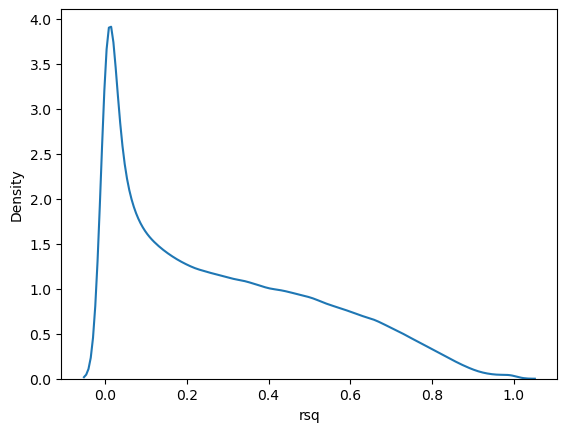

In [13]:
h9_rsq_df = wide_rsq_df[[('batch_1','h9')]]
h9_rsq_df.columns = ['rsq']
sns.kdeplot(data=h9_rsq_df.reset_index(), x="rsq")
plt.show()

In [207]:
print (
    np.percentile(h9_rsq_df['rsq'].dropna(), 95),
    np.percentile(h9_rsq_df['rsq'].dropna(), 75),    
    np.percentile(h9_rsq_df['rsq'].dropna(), 50),    
    np.percentile(h9_rsq_df['rsq'].dropna(), 25),
    np.percentile(h9_rsq_df['rsq'].dropna(), 5),    )

0.741685473685938 0.4679571350313938 0.23440777600257062 0.06238843962302864 0.002358545551939774


### 5.4 GO enrichment_table

In [24]:
h9_htg = gene_htg_by_crude_reac.loc[:, ('batch_1','h9')].to_frame('heterogeneity').dropna()
h9_htg_homo_10pct = np.percentile(h9_htg['heterogeneity'].dropna(), 10)
h9_htg_homo_25pct = np.percentile(h9_htg['heterogeneity'].dropna(), 25)
h9_htg_homo_75pct = np.percentile(h9_htg['heterogeneity'].dropna(), 75)
h9_htg_homo_90pct = np.percentile(h9_htg['heterogeneity'].dropna(), 90)

h9_htg.to_csv("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/total_h9_htg_geneset.csv")
h9_htg.loc[h9_htg['heterogeneity']<h9_htg_homo_10pct].to_csv("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_10pct_h9_htg_geneset.csv")
h9_htg.loc[h9_htg['heterogeneity']<h9_htg_homo_25pct].to_csv("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_25pct_h9_htg_geneset.csv")
h9_htg.loc[h9_htg['heterogeneity']>h9_htg_homo_75pct].to_csv("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_75pct_h9_htg_geneset.csv")
h9_htg.loc[h9_htg['heterogeneity']>h9_htg_homo_90pct].to_csv("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_90pct_h9_htg_geneset.csv")

In [ ]:
## 

In [ ]:
import goatools

In [36]:
from unipressed import UniprotkbClient, UniparcClient, IdMappingClient

In [62]:
request = IdMappingClient.submit(
    source="GeneCards", dest="UniProtKB", ids=h9_htg.index.unique().to_list()
)
time.sleep(1.0)

### Convert gene name to Uniport id

In [38]:
request = IdMappingClient.submit(
    source="UniProtKB_AC-ID", dest="Gene_Name", ids={"A1L190", "A0JP26", "A0PK11"})


In [48]:
request = IdMappingClient.submit(
    source="GeneCards", dest="UniProtKB", ids=["MTCH2", "CLRN2", "SYCE3","POTEB3"]
)
time.sleep(1.0)

In [49]:
list(request.each_result())

[{'from': 'MTCH2', 'to': 'Q9Y6C9'},
 {'from': 'CLRN2', 'to': 'A0PK11'},
 {'from': 'SYCE3', 'to': 'A1L190'},
 {'from': 'POTEB3', 'to': 'A0JP26'}]

In [47]:
UniprotkbClient.search(query={
    "and_": [
        {"family": "kinase"},
        {"organism_id": "9606"},
    ]
})

Search(query={'and_': [{'family': 'kinase'}, {'organism_id': '9606'}]}, dataset='uniprotkb', format='json', fields=None, include_isoform=True, size=500)

#### 5.5 convert genes to uniport id

In [53]:
request = IdMappingClient.submit(
    source="GeneCards", dest="UniProtKB", ids=h9_htg.loc[h9_htg['heterogeneity']<h9_htg_homo_10pct].index.unique().to_list()
)
time.sleep(1.0)

In [63]:
len(list(request.each_result()))

1156

In [68]:
request = IdMappingClient.submit(
    source="GeneCards", dest="UniProtKB", ids=['MALAT1']
)
time.sleep(1.0)
len(list(request.each_result()))

0

#### 5.6 GO by goenrich

##### 5.6.1 convert gene symbol to entrez id

In [2]:
import biomart

def get_ensembl_mappings():                                   
    # Set up connection to server                                               
    server = biomart.BiomartServer( "http://uswest.ensembl.org/biomart" )      
    mart = server.datasets['hsapiens_gene_ensembl']                            
    
    #server.show_databases()
    #server.show_datasets() # uses pprint behind the scenes
                                                                                
    # List the types of data we want                                            
    attributes = ['ensembl_transcript_id', 'gene_biotype', 'rfam', 'external_gene_name', 'entrezgene_id', ##go_id
                  'ensembl_gene_id', 'ensembl_peptide_id']
                                                                                
    # Get the mapping between the attributes                                    
    response = mart.search({'attributes': attributes})                          
    data = response.raw.data.decode('ascii')                                    
                                                                                
    ensembl_to_genesymbol = {}                                                  
    # Store the data in a dict                                                  
    for line in data.splitlines():                                              
        line = line.split('\t')                                                 
        # The entries are in the same order as in the `attributes` variable
        transcript_id = line[0]                                                 
        gene_symbol = line[1]                                                   
        ensembl_gene = line[2]                                                  
        ensembl_peptide = line[3]                                               
                                                                                
        # Some of these keys may be an empty string. If you want, you can 
        # avoid having a '' key in your dict by ensuring the 
        # transcript/gene/peptide ids have a nonzero length before
        # adding them to the dict
        ensembl_to_genesymbol[transcript_id] = gene_symbol                      
        ensembl_to_genesymbol[ensembl_gene] = gene_symbol                       
        ensembl_to_genesymbol[ensembl_peptide] = gene_symbol                
                                                                                
    return mart, ensembl_to_genesymbol

ModuleNotFoundError: No module named 'biomart'

In [99]:
mart, ensembl_to_gene_symbol = get_ensembl_mappings()

In [114]:
n = 0
for k,d in ensembl_to_gene_symbol.items():
    print (k, d)
    n += 1
    if n == 50:
        break

ENST00000387314 Mt_tRNA
 protein_coding
MT-TF Mt_tRNA
ENST00000389680 Mt_rRNA
MT-RNR1 Mt_rRNA
ENST00000387342 Mt_tRNA
MT-TV Mt_tRNA
ENST00000387347 Mt_rRNA
MT-RNR2 Mt_rRNA
ENST00000386347 Mt_tRNA
MT-TL1 Mt_tRNA
ENST00000361390 protein_coding
MT-ND1 protein_coding
ENST00000387365 Mt_tRNA
MT-TI Mt_tRNA
ENST00000387372 Mt_tRNA
MT-TQ Mt_tRNA
ENST00000387377 Mt_tRNA
MT-TM Mt_tRNA
ENST00000361453 protein_coding
MT-ND2 protein_coding
ENST00000387382 Mt_tRNA
MT-TW Mt_tRNA
ENST00000387392 Mt_tRNA
MT-TA Mt_tRNA
ENST00000387400 Mt_tRNA
MT-TN Mt_tRNA
ENST00000387405 Mt_tRNA
MT-TC Mt_tRNA
ENST00000387409 Mt_tRNA
MT-TY Mt_tRNA
ENST00000361624 protein_coding
MT-CO1 protein_coding
ENST00000387416 Mt_tRNA
MT-TS1 Mt_tRNA
ENST00000387419 Mt_tRNA
MT-TD Mt_tRNA
ENST00000361739 protein_coding
MT-CO2 protein_coding
ENST00000387421 Mt_tRNA
MT-TK Mt_tRNA
ENST00000361851 protein_coding
MT-ATP8 protein_coding
ENST00000361899 protein_coding
MT-ATP6 protein_coding
ENST00000362079 protein_coding
MT-CO3 protein_codi

In [110]:
pd.DataFrame.from_dict(ensembl_to_gene_symbol)

ValueError: If using all scalar values, you must pass an index

In [77]:
server.show_datasets() # uses pprint behind the scenes

{'abrachyrhynchus_gene_ensembl': Pink-footed goose genes (ASM259213v1),
 'abrachyrhynchus_genomic_sequence': Pink-footed goose sequences (ASM259213v1),
 'acalliptera_gene_ensembl': Eastern happy genes (fAstCal1.2),
 'acalliptera_genomic_sequence': Eastern happy sequences (fAstCal1.2),
 'acarolinensis_gene_ensembl': Green anole genes (AnoCar2.0v2),
 'acarolinensis_genomic_sequence': Green anole sequences (AnoCar2.0v2),
 'acchrysaetos_gene_ensembl': Golden eagle genes (bAquChr1.2),
 'acchrysaetos_genomic_sequence': Golden eagle sequences (bAquChr1.2),
 'acitrinellus_gene_ensembl': Midas cichlid genes (Midas_v5),
 'acitrinellus_genomic_sequence': Midas cichlid sequences (Midas_v5),
 'amelanoleuca_gene_ensembl': Giant panda genes (ASM200744v2),
 'amelanoleuca_genomic_sequence': Giant panda sequences (ASM200744v2),
 'amexicanus_gene_ensembl': Mexican tetra genes (Astyanax_mexicanus-2.0),
 'amexicanus_genomic_sequence': Mexican tetra sequences (Astyanax_mexicanus-2.0),
 'anancymaae_gene_ense

In [ ]:
miRNA_marg = server.datasets['hsapiens_mirna_target_feature']

In [83]:
from biomart import BiomartDataset

interpro = BiomartDataset("http://uswest.ensembl.org/biomart", name = 'entry' )

response = interpro.search({
'filters': { 'entry_id': 'Q9Y6C9' },
'attributes': [ 'entry_name', 'abstract' ]
})

IndexError: list index out of range

##### 5.6.2 goenrich

In [1]:
import goenrich

ModuleNotFoundError: No module named 'goenrich'

In [231]:
h9_background = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/total_h9_htg_geneset.convert_id.csv")
h9_htg_homo_top10pct = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_10pct_h9_htg_geneset.convert_id.csv")
h9_htg_homo_top25pct = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_25pct_h9_htg_geneset.convert_id.csv")
h9_htg_homo_top75pct = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_75pct_h9_htg_geneset.convert_id.csv")
h9_htg_homo_top90pct = load_large_dataFrame("../Current_Data/05.Gene_Heterogeneity/Go_enrichment/homo_90pct_h9_htg_geneset.convert_id.csv")

In [239]:
# build the ontology
O = goenrich.obo.ontology('../../../../FigureFactory/Gene_Ontology_Enrichment/GO_db/go-basic.obo')
# use all entrez geneid associations form gene2go as background
# use annot = goenrich.read.goa('db/gene_association.goa_human.gaf.gz') for uniprot
# use annot = goenrich.read.sgd('db/gene_association.sgd.gz') for yeast
gene2go = goenrich.read.gene2go('../../../../FigureFactory/Gene_Ontology_Enrichment/GO_db/gene2go.gz')

# propagate the background through the ontology
values = {k: set(v) for k,v in gene2go.groupby('GO_ID')['GeneID']}
background_attribute = 'gene2go'
goenrich.enrich.propagate(O, values, background_attribute)

# propagate the custom background through the ontology
# values = {}
# for k,v in gene2go.groupby('GO_ID')['GeneID']:
#     concat_lst = []
#     for v_gene in v:
#         if v_gene in h9_background['ENTREZID']:
#             concat_lst.append(v_gene)
#     if len(concat_lst) >= 1:
#         values[k] = set(concat_lst)
#     else:
#         pass
#background_attribute = 'custom'
background_attribute = 'gene2go'
goenrich.enrich.propagate(O, values, background_attribute)

In [240]:
# extract some list of entries as example query
# use query = annot['db_object_symbol'].unique()[:20]
# query = gene2go['GeneID'].unique()[:20]
query = h9_htg_homo_top75pct['ENTREZID'].unique()
#query = h9_htg_homo_top75pct['ENTREZID'].unique()
#query = h9_htg_homo_top75pct['ENTREZID'].unique()
#query = h9_htg_homo_top75pct['ENTREZID'].unique()

#query

In [241]:
# for additional export to graphviz just specify the gvfile argument
# the show argument keeps the graph reasonably small
df = goenrich.enrich.analyze(O, query, background_attribute, gvfile='test.dot')
df

,term,q,rejected,p,x,n,M,N,name,namespace
0,GO:0000001,NaN,NaN,NaN,0,0,20739,288,mitochondrion inheritance,biological_process
1,GO:0000002,NaN,NaN,NaN,0,27,20739,288,mitochondrial genome maintenance,biological_process
2,GO:0000003,NaN,NaN,NaN,33,1447,20739,288,reproduction,biological_process
3,GO:0000006,NaN,NaN,NaN,0,0,20739,288,high-affinity zinc transmembrane transporter a...,molecular_function
4,GO:0000007,NaN,NaN,NaN,0,0,20739,288,low-affinity zinc ion transmembrane transporte...,molecular_function
...,...,...,...,...,...,...,...,...,...,...
43330,GO:2001313,NaN,NaN,NaN,0,0,20739,288,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process
43331,GO:2001314,NaN,NaN,NaN,0,0,20739,288,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process
43332,GO:2001315,NaN,NaN,NaN,0,0,20739,288,UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...,biological_process
43333,GO:2001316,NaN,NaN,NaN,0,0,20739,288,kojic acid metabolic process,biological_process


In [255]:
df.loc[(df['q']<0.05)].sort_values('q').iloc[0:29]

,term,q,rejected,p,x,n,M,N,name,namespace
32762,GO:0098798,1.774313e-12,1.0,2.267203e-16,29,300,20739,288,mitochondrial protein-containing complex,cellular_component
4253,GO:0006412,4.488858e-11,1.0,1.147165e-14,30,375,20739,288,translation,biological_process
18801,GO:0043043,2.138465e-10,1.0,8.197542e-14,30,404,20739,288,peptide biosynthetic process,biological_process
3749,GO:0005759,2.746463e-09,1.0,1.403763e-12,31,482,20739,288,mitochondrial matrix,cellular_component
3736,GO:0005743,5.404603e-09,1.0,3.452979e-12,31,499,20739,288,mitochondrial inner membrane,cellular_component
40242,GO:1904813,2.245097e-06,1.0,2.008137e-09,14,124,20739,288,ficolin-1-rich granule lumen,cellular_component
24679,GO:0051082,2.245097e-06,1.0,2.008137e-09,14,124,20739,288,unfolded protein binding,molecular_function
11693,GO:0022613,3.305083e-06,1.0,3.378567e-09,26,477,20739,288,ribonucleoprotein complex biogenesis,biological_process
19905,GO:0044389,3.862858e-06,1.0,4.442336e-09,21,319,20739,288,ubiquitin-like protein ligase binding,molecular_function
363,GO:0000502,6.022116e-06,1.0,7.868153e-09,10,59,20739,288,proteasome complex,cellular_component


In [252]:
h9_background.loc[h9_background['ENTREZID'].isin([x for x in query if x in values['GO:0006412']])]

,SYMBOL,ENTREZID
539,MRPL11,65003
544,MRPL23,6150
548,MRPL36,64979
555,MRPS15,64960
557,MRPS18C,51023
868,RPL4,6124
874,RPL8,6132
885,RPS15A,6210


In [249]:
h9_background

,SYMBOL,ENTREZID
1,AARS1,16
15,ACAA2,10449
16,ACAT2,39
17,ACIN1,22985
18,ACLY,47
...,...,...
1176,ZNHIT1,10467
1177,ZNRD2,10534
1178,ZRANB2,9406
1179,ZSCAN10,84891
